In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from matplotlib.ticker import MaxNLocator

In [2]:
df = pd.read_csv(r"Cfile")

print(df.head())

                                     Company Name     ISIN Code Ticker Symbol  \
0                                    3i Group PLC  GB00B1YW4409           III   
1                                         A2A SpA  IT0001233417           A2A   
2                                   AAK AB (publ)           NaN           AAK   
3                                ABN Amro Bank NV           NaN           ABN   
4  ACS Actividades de Construccion y Servicios SA           NaN           ACS   

  Country of Exchange              NAICS National Industry Name  \
0      United Kingdom              Miscellaneous Intermediation   
1               Italy           Other Electric Power Generation   
2              Sweden       Fats and Oils Refining and Blending   
3         Netherlands                        Commercial Banking   
4               Spain  Highway, Street, and Bridge Construction   

      MarketCap_2023     MarketCap_2022     MarketCap_2021     MarketCap_2020  \
0  20,226,586,593.37  17,747,

In [3]:
# Convert wide format to long format
id_vars = ['Company Name', 'Ticker Symbol', 'Country of Exchange', 'NAICS National Industry Name']

# Reshape EPS, ROA, and ROE
financial_ratios = ['EPS', 'ROA', 'ROE']
df_long = df[id_vars].copy()

for ratio in financial_ratios:
    value_vars = [col for col in df.columns if ratio in col]  # Select relevant columns
    if not value_vars:
        print(f"No columns found for {ratio}, skipping...")
        continue  # Skip if no matching columns are found
    temp = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Year', value_name=ratio)
    temp['Year'] = temp['Year'].str.extract(r'(\d+)').astype(float)  # Extract year
    temp.dropna(subset=['Year'], inplace=True)  # Ensure no NaN in Year
    temp['Year'] = temp['Year'].astype(int)  # Convert to integer
    if 'Year' not in df_long:
        df_long = temp
    else:
        df_long = df_long.merge(temp, on=id_vars + ['Year'], how='outer')

# Repeat for ESG scores
esg_scores = ['ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap']
for esg in esg_scores:
    esg_cols = [col for col in df.columns if esg in col]
    if not esg_cols:
        print(f"No columns found for {esg}, skipping...")
        continue
    temp = df.melt(id_vars=id_vars, value_vars=esg_cols, var_name='Year', value_name=esg)
    temp['Year'] = temp['Year'].str.extract(r'(\d+)').astype(float)
    temp.dropna(subset=['Year'], inplace=True)
    temp['Year'] = temp['Year'].astype(int)
    df_long = df_long.merge(temp, on=id_vars + ['Year'], how='outer')

print(df_long)

        Company Name Ticker Symbol Country of Exchange  \
0       3i Group PLC           III      United Kingdom   
1       3i Group PLC           III      United Kingdom   
2       3i Group PLC           III      United Kingdom   
3       3i Group PLC           III      United Kingdom   
4       3i Group PLC           III      United Kingdom   
...              ...           ...                 ...   
9575  voestalpine AG           VOE             Austria   
9576  voestalpine AG           VOE             Austria   
9577  voestalpine AG           VOE             Austria   
9578  voestalpine AG           VOE             Austria   
9579  voestalpine AG           VOE             Austria   

             NAICS National Industry Name  Year   EPS    ROA    ROE  \
0            Miscellaneous Intermediation  2004  0.29   2.1%   3.5%   
1            Miscellaneous Intermediation  2005  0.38   2.4%   3.9%   
2            Miscellaneous Intermediation  2006  2.48  14.0%  22.1%   
3            Miscel

In [4]:
df_long['MarketCap'] = df_long['MarketCap'].replace(',', '', regex=True).astype(float)

# Clean percentage strings in ROE, ROA, and EPS if necessary
for col in ['ROE', 'ROA', 'EPS']:
    df_long[col] = (
        df_long[col]
        .astype(str)                      # convert everything to string
        .str.replace('%', '', regex=False)  # remove %
        .str.replace(',', '.', regex=False)  # if commas are used as decimals
    )

    # Convert to float, coercing errors to NaN
    df_long[col] = pd.to_numeric(df_long[col], errors='coerce')

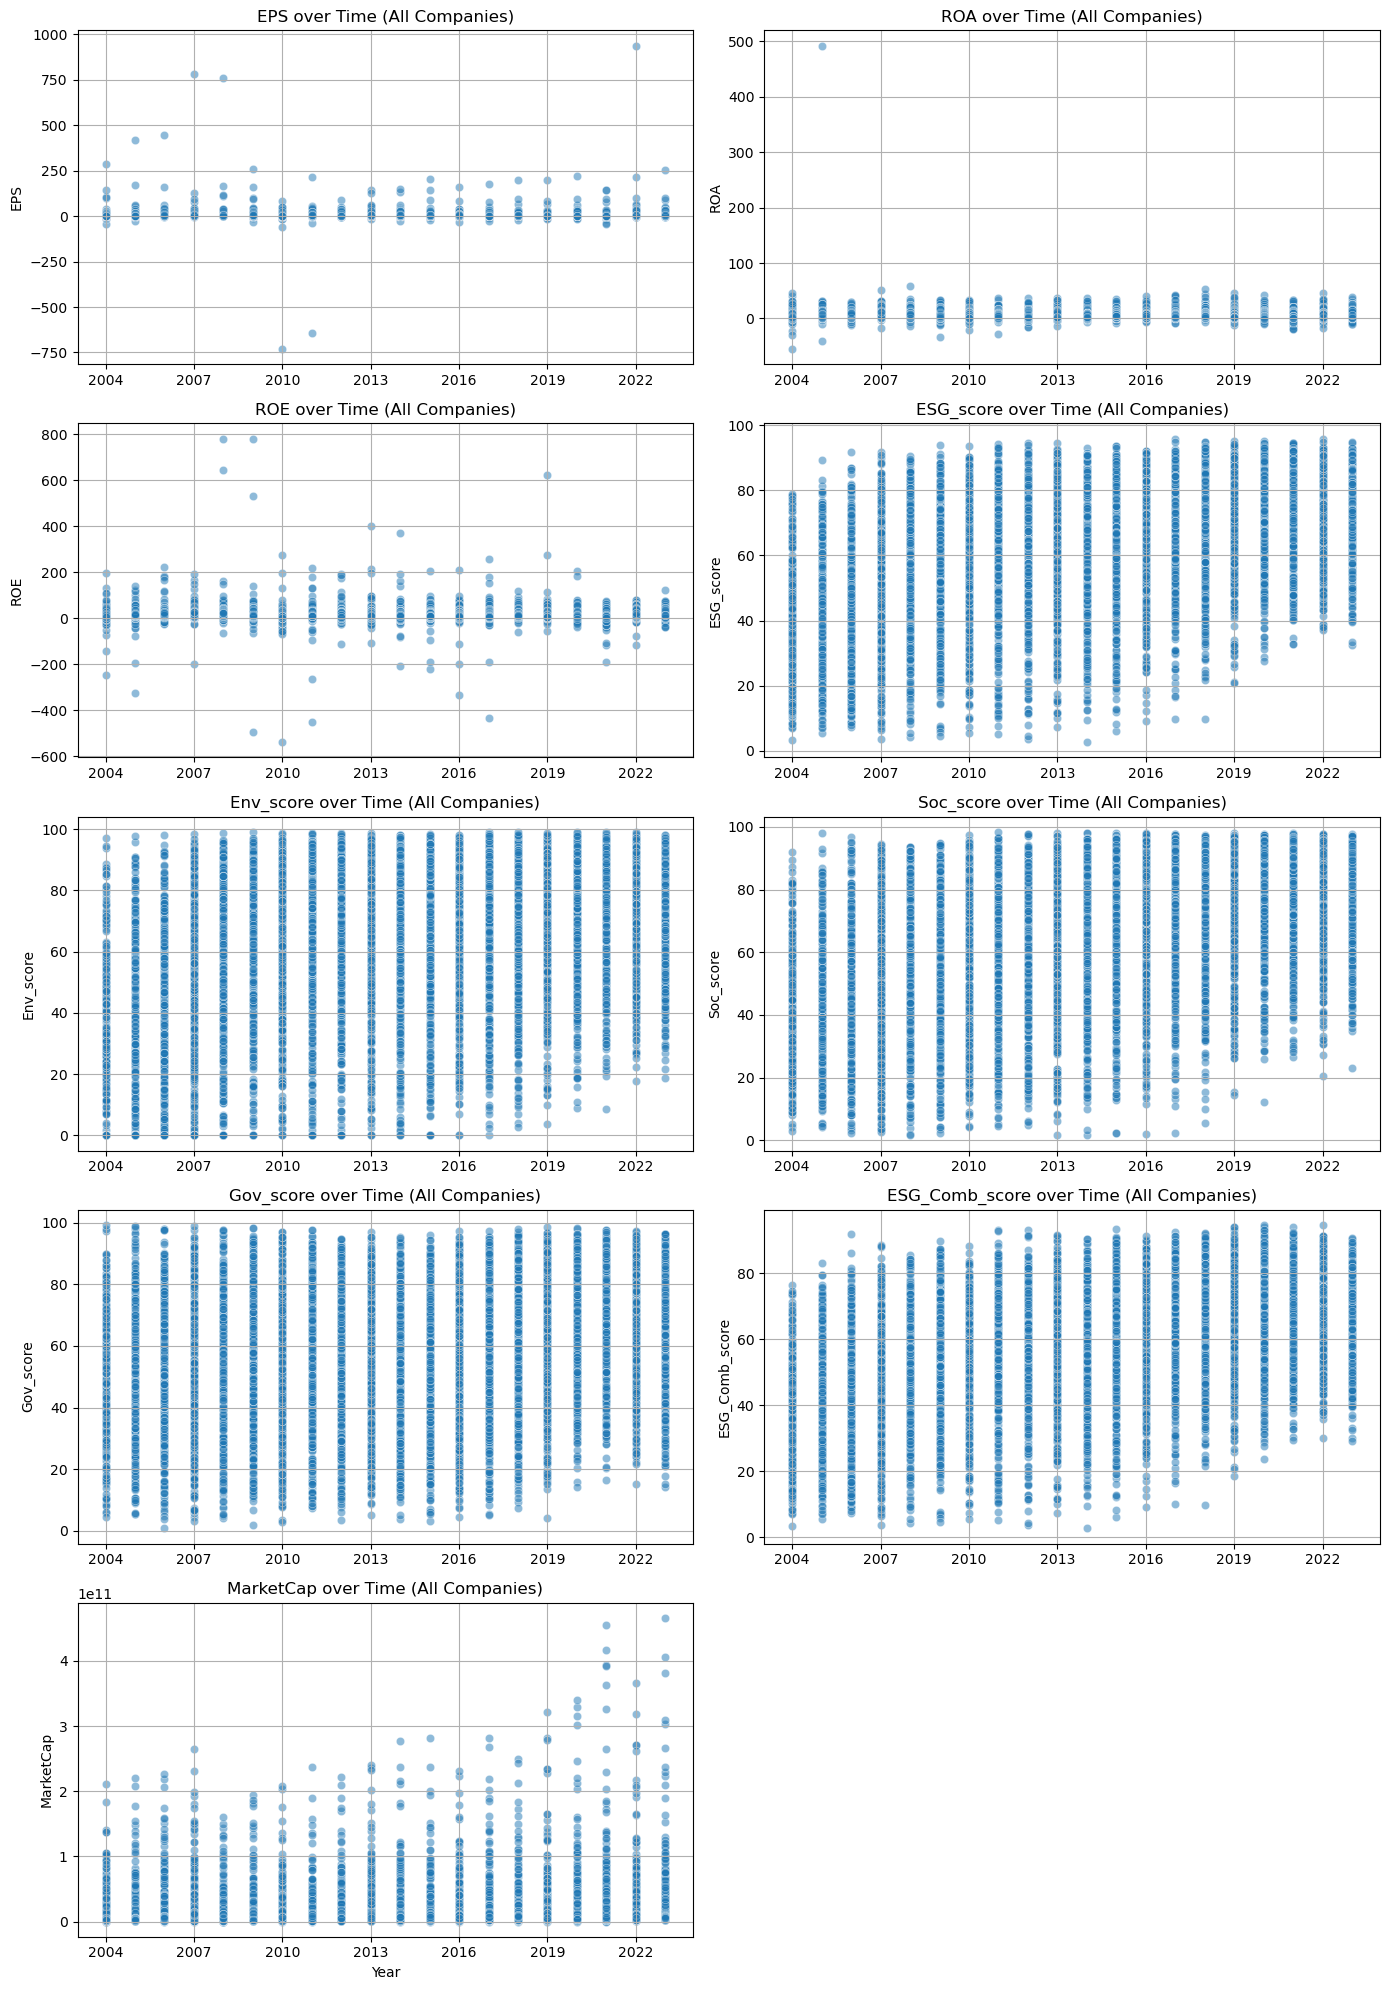

In [5]:
# Variables to plot
variables = ['EPS', 'ROA', 'ROE', 'ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap']

# Set up the subplot grid
n_vars = len(variables)
n_cols = 2
n_rows = (n_vars + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Loop through variables and create scatter plots
for i, var in enumerate(variables):
    sns.scatterplot(data=df_long, x='Year', y=var, alpha=0.5, ax=axes[i])
    axes[i].set_title(f'{var} over Time (All Companies)')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(var)
    axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[i].tick_params(labelbottom=True)  # <- Show x-axis labels
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("data_visualization_USA.png", dpi=300, bbox_inches="tight")
plt.show()

# Validity Check

### Check if ESG variables are between 0 - 100

In [8]:
# ESG columns to check
esg_columns = ['ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']

# Check for values outside [0, 100]
for col in esg_columns:
    invalid = df_long[(df_long[col] < 0) | (df_long[col] > 100)]
    if not invalid.empty:
        print(f"Out-of-range values found in '{col}':")
        print(invalid[['Ticker Symbol', 'Year', col]])
    else:
        print(f"All values in '{col}' are within the [0, 100] range.")

All values in 'ESG_score' are within the [0, 100] range.
All values in 'Env_score' are within the [0, 100] range.
All values in 'Soc_score' are within the [0, 100] range.
All values in 'Gov_score' are within the [0, 100] range.
All values in 'ESG_Comb_score' are within the [0, 100] range.


### check if Market capitalization is between valid range

In [10]:
invalid_marketcap = df_long[df_long['MarketCap'] < 0]

print(f"Invalid MarketCap: {len(invalid_marketcap)} rows")

Invalid MarketCap: 0 rows


### Check unreal fluctuations

In [12]:
import pandas as pd

# Sort the data by company and year
df_imputed_sorted = df_long.sort_values(by=['Company Name', 'Year']).copy()

# List of ESG-related columns to check
esg_columns = ['ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']

# Define threshold (adjustable)
threshold = 15

# Create a dictionary to store flagged rows
unreal_fluctuations_dict = {}

# Loop over each ESG column
for col in esg_columns:
    diff_col = f'{col}_diff'
    flag_col = f'{col}_unreal'
    
    # Calculate year-over-year difference
    df_imputed_sorted[diff_col] = df_imputed_sorted.groupby('Company Name')[col].diff()
    
    # Flag large changes
    df_imputed_sorted[flag_col] = df_imputed_sorted[diff_col].abs() > threshold
    
    # Store flagged rows for this ESG metric
    unreal_fluctuations_dict[col] = df_imputed_sorted[df_imputed_sorted[flag_col]]

    # Print how many rows were flagged
    print(f"{col}: {unreal_fluctuations_dict[col].shape[0]} unreal fluctuations (> {threshold} points)")

# Optional: view an example
df_imputed_sorted[['Company Name', 'Year'] + esg_columns + [f'{col}_diff' for col in esg_columns]]

ESG_score: 388 unreal fluctuations (> 15 points)
Env_score: 731 unreal fluctuations (> 15 points)
Soc_score: 653 unreal fluctuations (> 15 points)
Gov_score: 1557 unreal fluctuations (> 15 points)
ESG_Comb_score: 1059 unreal fluctuations (> 15 points)


,Company Name,Year,ESG_score,Env_score,Soc_score,Gov_score,ESG_Comb_score,ESG_score_diff,Env_score_diff,Soc_score_diff,Gov_score_diff,ESG_Comb_score_diff
0,3i Group PLC,2004,56.33,34.41,42.07,82.90,56.33,NaN,NaN,NaN,NaN,NaN
1,3i Group PLC,2005,26.43,42.74,29.03,27.23,20.91,-29.90,8.33,-13.04,-55.67,-35.42
2,3i Group PLC,2006,53.34,55.59,41.85,70.36,53.34,26.91,12.85,12.82,43.13,32.43
3,3i Group PLC,2007,53.66,78.74,48.50,53.05,53.66,0.32,23.15,6.65,-17.31,0.32
4,3i Group PLC,2008,49.42,73.97,45.60,49.72,49.42,-4.24,-4.77,-2.90,-3.33,-4.24
...,...,...,...,...,...,...,...,...,...,...,...,...
9575,voestalpine AG,2019,61.68,68.87,58.69,56.26,49.48,0.33,4.72,-3.27,-0.07,3.06
9576,voestalpine AG,2020,70.14,69.02,73.07,66.95,67.66,8.46,0.15,14.38,10.69,18.18
9577,voestalpine AG,2021,64.83,68.42,66.21,57.43,64.83,-5.31,-0.60,-6.86,-9.52,-2.83
9578,voestalpine AG,2022,64.58,69.30,66.02,55.46,64.58,-0.25,0.88,-0.19,-1.97,-0.25


In [13]:
# List of ESG variables and their corresponding flag columns
esg_columns = ['ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']
flag_columns = [f'{col}_unreal' for col in esg_columns]

# Filter rows where all ESG variables have unreal fluctuations
all_unreal = df_imputed_sorted[df_imputed_sorted[flag_columns].all(axis=1)]

# Print the number of such rows
print(f"Number of rows with unreal fluctuations in ALL ESG variables: {all_unreal.shape[0]}")

# Optional: view a sample of these rows
all_unreal[['Company Name', 'Year'] + esg_columns + flag_columns]

Number of rows with unreal fluctuations in ALL ESG variables: 48


,Company Name,Year,ESG_score,Env_score,Soc_score,Gov_score,ESG_Comb_score,ESG_score_unreal,Env_score_unreal,Soc_score_unreal,Gov_score_unreal,ESG_Comb_score_unreal
82,ACS Actividades de Construccion y Servicios SA,2006,62.12,52.26,73.71,59.94,62.12,True,True,True,True,True
448,Aegon Ltd,2012,15.76,19.05,14.12,22.92,15.76,True,True,True,True,True
449,Aegon Ltd,2013,81.05,77.39,92.27,77.34,81.05,True,True,True,True,True
504,Ageas SA,2008,43.26,26.21,29.95,71.97,28.57,True,True,True,True,True
541,Akzo Nobel NV,2005,70.22,68.65,68.25,76.36,70.22,True,True,True,True,True
575,Alcon AG,2019,68.65,28.93,68.46,87.44,68.65,True,True,True,True,True
583,Alfa Laval AB,2007,57.95,61.70,41.19,75.43,57.95,True,True,True,True,True
783,Anglo American PLC,2007,72.94,65.44,81.60,69.51,54.65,True,True,True,True,True
871,Arkema SA,2015,74.81,90.99,53.92,81.62,74.81,True,True,True,True,True
901,Assa Abloy AB,2005,48.80,15.92,57.19,78.41,48.80,True,True,True,True,True


In [14]:
#Check how many unreal fluctuations a company has
# Count number of 'all unreal' rows per company
unreal_counts = all_unreal.groupby('Company Name').size().reset_index(name='Num_unreal_fluctuations')

# Sort by number of unreal fluctuations (optional)
unreal_counts = unreal_counts.sort_values(by='Num_unreal_fluctuations', ascending=False)

# Display the result
print(unreal_counts)

                                         Company Name  Num_unreal_fluctuations
39                                 Travis Perkins PLC                        2
29                                       Rockwool A/S                        2
31                                          Sanofi SA                        2
1                                           Aegon Ltd                        2
0      ACS Actividades de Construccion y Servicios SA                        1
32                                     Stora Enso Oyj                        1
24                                          Mondi PLC                        1
25                                          Neste Oyj                        1
26                                      Novozymes A/S                        1
27                                          Orkla ASA                        1
28     Recordati Industria Chimica e Farmaceutica SpA                        1
30                                             SGS S

In [15]:
# Total number of rows per company (all years)
total_counts = df_imputed_sorted.groupby('Company Name').size().reset_index(name='Total_rows')

# Number of rows with all ESG variables unreal per company
unreal_counts = all_unreal.groupby('Company Name').size().reset_index(name='Unreal_fluctuations')

# Merge both counts
company_fluctuation_summary = pd.merge(unreal_counts, total_counts, on='Company Name')

# Optional: add a percentage column
company_fluctuation_summary['Percentage_unreal'] = (
    100 * company_fluctuation_summary['Unreal_fluctuations'] / company_fluctuation_summary['Total_rows']
).round(2)

# Sort by highest percentage of unreal fluctuations
company_fluctuation_summary = company_fluctuation_summary.sort_values(by='Percentage_unreal', ascending=False)

# Display
print(company_fluctuation_summary)

                                         Company Name  Unreal_fluctuations  \
39                                 Travis Perkins PLC                    2   
29                                       Rockwool A/S                    2   
31                                          Sanofi SA                    2   
1                                           Aegon Ltd                    2   
0      ACS Actividades de Construccion y Servicios SA                    1   
32                                     Stora Enso Oyj                    1   
24                                          Mondi PLC                    1   
25                                          Neste Oyj                    1   
26                                      Novozymes A/S                    1   
27                                          Orkla ASA                    1   
28     Recordati Industria Chimica e Farmaceutica SpA                    1   
30                                             SGS SA           

In [16]:
# List of ESG variables and their corresponding flag columns
esg_columns = ['ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']
flag_columns = [f'{col}_unreal' for col in esg_columns]

# Filter rows where NOT all ESG variables have unreal fluctuations
df_filtered = df_imputed_sorted[~df_imputed_sorted[flag_columns].all(axis=1)]

# Print the number of rows removed
num_removed = df_imputed_sorted.shape[0] - df_filtered.shape[0]
print(f"Number of rows removed with unreal fluctuations in ALL ESG variables: {num_removed}")

Number of rows removed with unreal fluctuations in ALL ESG variables: 48


In [17]:
df_filtered

,Company Name,Ticker Symbol,Country of Exchange,NAICS National Industry Name,Year,EPS,ROA,ROE,ESG_score,Env_score,...,ESG_score_diff,ESG_score_unreal,Env_score_diff,Env_score_unreal,Soc_score_diff,Soc_score_unreal,Gov_score_diff,Gov_score_unreal,ESG_Comb_score_diff,ESG_Comb_score_unreal
0,3i Group PLC,III,United Kingdom,Miscellaneous Intermediation,2004,0.29,2.1,3.5,56.33,34.41,...,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
1,3i Group PLC,III,United Kingdom,Miscellaneous Intermediation,2005,0.38,2.4,3.9,26.43,42.74,...,-29.90,True,8.33,False,-13.04,False,-55.67,True,-35.42,True
2,3i Group PLC,III,United Kingdom,Miscellaneous Intermediation,2006,2.48,14.0,22.1,53.34,55.59,...,26.91,True,12.85,False,12.82,False,43.13,True,32.43,True
3,3i Group PLC,III,United Kingdom,Miscellaneous Intermediation,2007,3.13,16.0,25.6,53.66,78.74,...,0.32,False,23.15,True,6.65,False,-17.31,True,0.32,False
4,3i Group PLC,III,United Kingdom,Miscellaneous Intermediation,2008,2.04,9.7,16.1,49.42,73.97,...,-4.24,False,-4.77,False,-2.90,False,-3.33,False,-4.24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9575,voestalpine AG,VOE,Austria,Steel Foundries (except Investment),2019,2.58,2.6,6.3,61.68,68.87,...,0.33,False,4.72,False,-3.27,False,-0.07,False,3.06,False
9576,voestalpine AG,VOE,Austria,Steel Foundries (except Investment),2020,-1.35,-1.5,-3.7,70.14,69.02,...,8.46,False,0.15,False,14.38,False,10.69,False,18.18,True
9577,voestalpine AG,VOE,Austria,Steel Foundries (except Investment),2021,0.29,0.3,0.8,64.83,68.42,...,-5.31,False,-0.60,False,-6.86,False,-9.52,False,-2.83,False
9578,voestalpine AG,VOE,Austria,Steel Foundries (except Investment),2022,7.80,8.1,20.9,64.58,69.30,...,-0.25,False,0.88,False,-0.19,False,-1.97,False,-0.25,False


# Outlier detection by using Boxplots, IQR-method per variable per company

In [19]:
df_imputed = df_filtered

In [20]:
import pandas as pd

# Define the columns you want to check for outliers
columns_to_check = [
    'EPS', 'ROA', 'ROE', 'ESG_score', 'Env_score',
    'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap'
]

# Create a copy to avoid modifying the original
df_outliers_flagged = df_imputed.copy()
df_outliers_flagged['Outlier'] = False  # Add a new column to mark outliers

# Set a more lenient threshold
threshold = 3.0

# Loop through each column and each company
for col in columns_to_check:
    for ticker, group in df_outliers_flagged.groupby('Ticker Symbol'):
        q1 = group[col].quantile(0.25)
        q3 = group[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr

        outlier_mask = (group[col] < lower_bound) | (group[col] > upper_bound)

        # Flag the outliers
        df_outliers_flagged.loc[group[outlier_mask].index, 'Outlier'] = True

# Optionally: display the detected outliers
outliers = df_outliers_flagged[df_outliers_flagged['Outlier']]
print(f"Number of detected outliers: {len(outliers)}")
print(outliers[['Ticker Symbol', 'Year'] + columns_to_check + ['Outlier']])


Number of detected outliers: 770
     Ticker Symbol  Year    EPS   ROA   ROE  ESG_score  Env_score  Soc_score  \
5              III  2009  -4.82 -32.7 -65.8      57.82      72.19      52.79   
77             ABN  2021  -0.21   0.0  -0.9      67.64      92.02      62.48   
80             ACS  2004   1.14   2.8  16.5      47.50      58.07      36.87   
81             ACS  2005   1.54   3.9  22.4      35.65      29.21      44.35   
97             ACS  2021   2.29   NaN  13.5      68.12      82.84      87.87   
...            ...   ...    ...   ...   ...        ...        ...        ...   
9536           ZAL  2020   0.43   2.6   6.2      83.54      77.44      76.63   
9541          ZURN  2005  17.98   0.8  12.6      50.48      51.71      32.46   
9542          ZURN  2006  22.00   1.0  14.9      39.57      46.81      15.86   
9543          ZURN  2007  31.07   1.3  18.0      53.41      49.31      43.56   
9544          ZURN  2008  39.06   1.5  20.4      63.81      90.85      43.78   

      

In [21]:
# Remove the rows where 'Outlier' is True
df_cleaned = df_outliers_flagged[df_outliers_flagged['Outlier'] == False].copy()

# Optional: drop the 'Outlier' column if you no longer need it
df_cleaned.drop(columns='Outlier', inplace=True)

# Check how many rows are left
print(f"Number of rows after removing outliers: {len(df_cleaned)}")

Number of rows after removing outliers: 8762


# Missing Values

In [23]:
# Define the desired columns
columns_to_keep = [
    'Company Name', 'Ticker Symbol', 'Country of Exchange', 'NAICS National Industry Name',
    'Year', 'EPS', 'ROA', 'ROE', 'ESG_score', 'Env_score',
    'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap'
]

# Filter the DataFrame
df_long = df_cleaned[columns_to_keep]

In [24]:
nan_per_column = df_long.isna().sum()
print(nan_per_column)

Company Name                       0
Ticker Symbol                      0
Country of Exchange                0
NAICS National Industry Name       0
Year                               0
EPS                             1058
ROA                             1835
ROE                             1191
ESG_score                       1697
Env_score                       1697
Soc_score                       1697
Gov_score                       1697
ESG_Comb_score                  1697
MarketCap                        934
dtype: int64


### Checking if there is a year that is having for one variable only NaN's

In [26]:
# Check if there is a variable in one year that is containing only NaN's
# Group by Year and check for columns that are all NaN in any year
nan_summary = df_long.groupby("Year").apply(lambda g: g.isna().all()).T

# Filter to show only columns with any True (i.e., all NaNs in at least one year)
only_nan_columns_per_year = nan_summary.loc[nan_summary.any(axis=1)]

print("Variables that have only NaNs in at least one year:")
print(only_nan_columns_per_year)

Variables that have only NaNs in at least one year:
Empty DataFrame
Columns: [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Index: []


C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\1504384806.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_summary = df_long.groupby("Year").apply(lambda g: g.isna().all()).T


### Remove companies with more than 70% NaN's for ESG variables and for Financial Ratios

In [28]:
# ESG
# Total number of years available per company (based on ESG_score)
total_years_per_company = df_long.groupby('Company Name')['ESG_score'].size()

# Number of missing ESG scores per company
missing_esg_per_company = df_long.groupby('Company Name')['ESG_score'].apply(lambda x: x.isna().sum())

# Calculate missing ratio
missing_ratio = (missing_esg_per_company / total_years_per_company)

# Filter companies with >80% missing ESG_score
high_missing_companies = missing_ratio[missing_ratio > 0.69]

# Display company names
print("Companies with more than 70% missing ESG scores:")
print(high_missing_companies.sort_values(ascending=False))

Companies with more than 70% missing ESG scores:
Company Name
Dr Ing hc F Porsche AG                  0.950000
Vidrala SA                              0.900000
Iveco Group NV                          0.900000
Haleon PLC                              0.900000
Addtech AB                              0.875000
Swissquote Group Holding SA             0.875000
Daimler Truck Holding AG                0.850000
Volvo Car AB                            0.850000
Azelis Group NV                         0.850000
Technip Energies NV                     0.850000
Prosus NV                               0.800000
Allegro.eu SA                           0.800000
Siemens Energy AG                       0.800000
JDE Peets NV                            0.789474
Talanx AG                               0.789474
Verallia SA                             0.789474
P/F Bakkafrost                          0.777778
ALK-Abello A/S                          0.777778
Alcon AG                                0.777778
Thule G

In [29]:
# Step 1: Calculate the percentage of missing ESG scores per company
total_years_per_company = df_long.groupby('Company Name')['ESG_score'].size()
missing_esg_per_company = df_long.groupby('Company Name')['ESG_score'].apply(lambda x: x.isna().sum())
missing_ratio = missing_esg_per_company / total_years_per_company

# Step 2: Identify companies with more than 70% missing ESG scores
companies_to_remove = missing_ratio[missing_ratio > 0.69].index

# Step 3: Remove them from the dataset
df_long_cleaned = df_long[~df_long['Company Name'].isin(companies_to_remove)].copy()

# (Optional) Display how many companies were removed
print(f"Removed {len(companies_to_remove)} companies with >=70% missing ESG scores.")

Removed 41 companies with >=70% missing ESG scores.


In [30]:
# Financial Ratio
# Total number of years available per company (based on ESG_score)
total_years_per_company = df_long_cleaned.groupby('Company Name')['ROA'].size()

# Number of missing ESG scores per company
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['ROA'].apply(lambda x: x.isna().sum())

# Calculate missing ratio
missing_ratio = (missing_esg_per_company / total_years_per_company)

# Filter companies with >70% missing ESG_score
high_missing_companies = missing_ratio[missing_ratio > 0.69]

# Display company names
print("Companies with more than 70% missing EPS:")
print(high_missing_companies.sort_values(ascending=False))

Companies with more than 70% missing EPS:
Company Name
Tritax Big Box Reit PLC        0.947368
SIG Group AG                   0.800000
Sopra Steria Group SA          0.800000
Bollore SE                     0.750000
Knorr Bremse AG                0.736842
Ackermans & Van Haaren NV      0.722222
ConvaTec Group PLC             0.722222
Ferrari NV                     0.722222
SSAB AB                        0.705882
FinecoBank Banca Fineco SpA    0.700000
Interpump Group SpA            0.700000
Softcat PLC                    0.700000
Name: ROA, dtype: float64


In [31]:
# Financial Ratio
# Total number of years available per company (based on ESG_score)
total_years_per_company = df_long_cleaned.groupby('Company Name')['ROE'].size()

# Number of missing ESG scores per company
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['ROE'].apply(lambda x: x.isna().sum())

# Calculate missing ratio
missing_ratio = (missing_esg_per_company / total_years_per_company)

# Filter companies with >70% missing ESG_score
high_missing_companies = missing_ratio[missing_ratio > 0.69]

# Display company names
print("Companies with more than 70% missing EPS:")
print(high_missing_companies.sort_values(ascending=False))

Companies with more than 70% missing EPS:
Company Name
Tritax Big Box Reit PLC    0.947368
SIG Group AG               0.800000
Knorr Bremse AG            0.736842
ConvaTec Group PLC         0.722222
Name: ROE, dtype: float64


In [32]:
# Financial Ratio
# Total number of years available per company (based on ESG_score)
total_years_per_company = df_long_cleaned.groupby('Company Name')['EPS'].size()

# Number of missing ESG scores per company
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['EPS'].apply(lambda x: x.isna().sum())

# Calculate missing ratio
missing_ratio = (missing_esg_per_company / total_years_per_company)

# Filter companies with >70% missing ESG_score
high_missing_companies = missing_ratio[missing_ratio > 0.69]

# Display company names
print("Companies with more than 70% missing EPS:")
print(high_missing_companies.sort_values(ascending=False))

Companies with more than 70% missing EPS:
Company Name
SIG Group AG          0.750000
Knorr Bremse AG       0.736842
ConvaTec Group PLC    0.722222
Name: EPS, dtype: float64


In [33]:
# Step 1: Calculate the percentage of missing ESG scores per company
total_years_per_company = df_long_cleaned.groupby('Company Name')['ROA'].size()
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['ROA'].apply(lambda x: x.isna().sum())
missing_ratio = missing_esg_per_company / total_years_per_company

# Step 2: Identify companies with more than 70% missing ESG scores
companies_to_remove = missing_ratio[missing_ratio > 0.69].index

# Step 3: Remove them from the dataset
df_long_cleaned = df_long_cleaned[~df_long_cleaned['Company Name'].isin(companies_to_remove)].copy()

# (Optional) Display how many companies were removed
print(f"Removed {len(companies_to_remove)} companies with >=70% missing financial ratio scores.")

Removed 12 companies with >=70% missing financial ratio scores.


In [34]:
# Step 1: Calculate the percentage of missing ESG scores per company
total_years_per_company = df_long_cleaned.groupby('Company Name')['ROE'].size()
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['ROE'].apply(lambda x: x.isna().sum())
missing_ratio = missing_esg_per_company / total_years_per_company

# Step 2: Identify companies with more than 70% missing ESG scores
companies_to_remove = missing_ratio[missing_ratio > 0.69].index

# Step 3: Remove them from the dataset
df_long_cleaned = df_long_cleaned[~df_long_cleaned['Company Name'].isin(companies_to_remove)].copy()

# (Optional) Display how many companies were removed
print(f"Removed {len(companies_to_remove)} companies with >=70% missing financial ratio scores.")

Removed 0 companies with >=70% missing financial ratio scores.


In [35]:
# Step 1: Calculate the percentage of missing ESG scores per company
total_years_per_company = df_long_cleaned.groupby('Company Name')['EPS'].size()
missing_esg_per_company = df_long_cleaned.groupby('Company Name')['EPS'].apply(lambda x: x.isna().sum())
missing_ratio = missing_esg_per_company / total_years_per_company

# Step 2: Identify companies with more than 70% missing ESG scores
companies_to_remove = missing_ratio[missing_ratio > 0.69].index

# Step 3: Remove them from the dataset
df_long_cleaned = df_long_cleaned[~df_long_cleaned['Company Name'].isin(companies_to_remove)].copy()

# (Optional) Display how many companies were removed
print(f"Removed {len(companies_to_remove)} companies with >=70% missing financial ratio scores.")

Removed 0 companies with >=70% missing financial ratio scores.


### Removing the data that is missing at the beginning or end of the time period
I don't know why, but the function needs to be runned two times

In [37]:
def remove_leading_trailing_nans(df, value_col):
    cleaned_dfs = []

    for ticker, group in df.groupby('Ticker Symbol'):
        group_sorted = group.sort_values('Year')
        values = group_sorted[value_col]

        # Get first and last valid indices
        first_valid_idx = values.first_valid_index()
        last_valid_idx = values.last_valid_index()

        # Only keep rows between those indices
        if first_valid_idx is not None and last_valid_idx is not None:
            group_cleaned = group_sorted.loc[first_valid_idx:last_valid_idx]
            cleaned_dfs.append(group_cleaned)

    # Combine cleaned groups
    cleaned_df = pd.concat(cleaned_dfs, ignore_index=True)
    return cleaned_df

In [38]:
value_cols = ['ROA', 'ROE', 'EPS', 'MarketCap', 'ESG_score', 
              'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']

for col in value_cols:
    df_long = remove_leading_trailing_nans(df_long, col)

In [39]:
def remove_leading_trailing_nans(df, value_col):
    cleaned_dfs = []

    for ticker, group in df.groupby('Ticker Symbol'):
        group_sorted = group.sort_values('Year')
        values = group_sorted[value_col]

        # Get first and last valid indices
        first_valid_idx = values.first_valid_index()
        last_valid_idx = values.last_valid_index()

        # Only keep rows between those indices
        if first_valid_idx is not None and last_valid_idx is not None:
            group_cleaned = group_sorted.loc[first_valid_idx:last_valid_idx]
            cleaned_dfs.append(group_cleaned)

    # Combine cleaned groups
    cleaned_df = pd.concat(cleaned_dfs, ignore_index=True)
    return cleaned_df

In [40]:
value_cols = ['ROA', 'ROE', 'EPS', 'MarketCap', 'ESG_score', 
              'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']

for col in value_cols:
    df_long = remove_leading_trailing_nans(df_long, col)

### Check if there are companies with random gaps of multiple consequetive missing values

In [42]:
import pandas as pd

# Assuming df_long is your DataFrame
df = df_long.copy()

# Step 1: Define the variables to check
variables_to_check = ['EPS', 'ROA', 'ROE', 'ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap']

# Step 2: Function to identify large gaps in a time series for one variable
def has_large_gaps(series_years):
    sorted_years = sorted(series_years)
    gaps = [sorted_years[i+1] - sorted_years[i] for i in range(len(sorted_years) - 1)]
    large_gaps = [gap for gap in gaps if gap >= 3]
    return len(large_gaps) >= 2

# Step 3: Identify companies with bad data
companies_to_remove = set()

for company, company_df in df.groupby("Company Name"):
    for var in variables_to_check:
        # Get the years where the variable is not null
        valid_years = company_df.loc[company_df[var].notnull(), 'Year'].tolist()
        if has_large_gaps(valid_years):
            companies_to_remove.add(company)
            break  # No need to check other variables for this company

# Step 4: Remove companies with unreliable data
df_cleaned = df[~df['Company Name'].isin(companies_to_remove)].reset_index(drop=True)

print(f"Removed {len(companies_to_remove)} companies due to large data gaps.")

Removed 12 companies due to large data gaps.


In [43]:
df_long = df_cleaned

In [44]:
nan_per_column = df_long.isna().sum()
print(nan_per_column)

Company Name                      0
Ticker Symbol                     0
Country of Exchange               0
NAICS National Industry Name      0
Year                              0
EPS                              10
ROA                             372
ROE                              68
ESG_score                        13
Env_score                        13
Soc_score                        13
Gov_score                        13
ESG_Comb_score                   13
MarketCap                        16
dtype: int64


### Check if the remaining NaN's are between valid values such that these can be imputed

In [46]:
import pandas as pd
import numpy as np

# Create a copy of the original data
df_imputed = df_long.copy()

# Columns to impute
columns_to_impute = [
    'EPS', 'ROA', 'ROE', 'ESG_score', 'Env_score',
    'Soc_score', 'Gov_score', 'ESG_Comb_score', 'MarketCap'
]

# Apply only midpoint imputation (average of previous and next valid values)
for col in columns_to_impute:
    def midpoint_impute(group):
        # Use only when missing values are between two valid values
        values = group.values
        for i in range(1, len(values) - 1):
            if pd.isna(values[i]) and not pd.isna(values[i-1]) and not pd.isna(values[i+1]):
                values[i] = (values[i-1] + values[i+1]) / 2
        return pd.Series(values, index=group.index)

    df_imputed[col] = df_imputed.groupby('Ticker Symbol')[col].transform(midpoint_impute)

In [47]:
nan_per_column = df_imputed.isna().sum()
print(nan_per_column)

Company Name                      0
Ticker Symbol                     0
Country of Exchange               0
NAICS National Industry Name      0
Year                              0
EPS                               3
ROA                             225
ROE                              15
ESG_score                         4
Env_score                         4
Soc_score                         4
Gov_score                         4
ESG_Comb_score                    4
MarketCap                         0
dtype: int64


In [48]:
df_imputed

,Company Name,Ticker Symbol,Country of Exchange,NAICS National Industry Name,Year,EPS,ROA,ROE,ESG_score,Env_score,Soc_score,Gov_score,ESG_Comb_score,MarketCap
0,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2016,2.93,5.1,20.1,66.40,70.25,68.00,56.88,66.40,1.387610e+10
1,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2017,4.17,7.7,20.4,68.66,68.28,74.58,59.31,68.66,2.089835e+10
2,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2018,12.25,18.6,42.2,73.62,72.78,74.72,73.21,73.62,9.062689e+09
3,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2019,10.74,16.3,34.2,74.58,69.59,71.77,88.15,74.58,8.503184e+09
4,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2020,3.26,4.9,10.5,76.25,74.38,69.86,90.37,76.25,1.191101e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2019,24.28,0.9,13.1,89.93,90.84,91.69,86.64,79.96,6.138598e+10
6592,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2020,27.69,1.0,12.7,88.87,89.60,90.93,85.50,50.53,6.349212e+10
6593,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2021,25.56,0.9,10.5,89.19,86.31,87.95,97.03,76.17,6.604281e+10
6594,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2022,34.66,1.2,13.7,87.89,85.62,87.16,94.72,78.62,7.199106e+10


### What to do with the remaining NaN's?
Probably these are >= 2 consecutive NaN's such that you can not impute it by taking the mean

In [50]:
import pandas as pd

def max_consecutive_nans(df, group_col, target_col):
    """
    Returns the maximum number of consecutive NaNs in the target column
    grouped by the group_col (e.g., 'Ticker Symbol').
    """
    def max_run_length(group):
        is_nan = group[target_col].isna()
        max_len = 0
        current_len = 0
        for val in is_nan:
            if val:
                current_len += 1
                max_len = max(max_len, current_len)
            else:
                current_len = 0
        return max_len

    return df.groupby(group_col).apply(max_run_length).max()

# Check max consecutive NaNs in each column
for col in ['EPS', 'ROA', 'ROE', 'ESG_score']:
    max_consec = max_consecutive_nans(df_imputed, group_col='Ticker Symbol', target_col=col)
    print(f"{col}: max {max_consec} consecutive NaNs")

EPS: max 3 consecutive NaNs
ROA: max 9 consecutive NaNs
ROE: max 3 consecutive NaNs
ESG_score: max 2 consecutive NaNs


C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\1808455849.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(max_run_length).max()
C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\1808455849.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(max_run_length).max()
C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\180845

In [51]:
import pandas as pd

def find_consecutive_nans_roa(df, col='ROA', min_consecutive=4):
    """
    Find sequences of min_consecutive or more NaNs in the ROA column per company.
    Returns a DataFrame with Company Name, Ticker, Start Year, End Year, and Length.
    """
    results = []

    # Sort to ensure chronological order
    df_sorted = df.sort_values(by=['Ticker Symbol', 'Year'])

    for ticker, group in df_sorted.groupby('Ticker Symbol'):
        group = group.reset_index(drop=True)
        is_nan = group[col].isna()
        run_start = None
        run_length = 0

        for i, val in enumerate(is_nan):
            if val:
                if run_start is None:
                    run_start = i
                run_length += 1
            else:
                if run_length >= min_consecutive:
                    start_year = group.loc[run_start, 'Year']
                    end_year = group.loc[i - 1, 'Year']
                    company_name = group.loc[run_start, 'Company Name']
                    results.append({
                        'Company Name': company_name,
                        'Ticker Symbol': ticker,
                        'Start Year': start_year,
                        'End Year': end_year,
                        'Number of Consecutive NaNs': run_length
                    })
                run_start = None
                run_length = 0

        # Handle case where NaN run is at the end
        if run_length >= min_consecutive:
            start_year = group.loc[run_start, 'Year']
            end_year = group.loc[len(group) - 1, 'Year']
            company_name = group.loc[run_start, 'Company Name']
            results.append({
                'Company Name': company_name,
                'Ticker Symbol': ticker,
                'Start Year': start_year,
                'End Year': end_year,
                'Number of Consecutive NaNs': run_length
            })

    return pd.DataFrame(results)

# Example usage
roa_nans_df = find_consecutive_nans_roa(df_imputed, col='ROA', min_consecutive=4)

# Display result
print(roa_nans_df)

                 Company Name Ticker Symbol  Start Year  End Year  \
0                     A2A SpA           A2A        2012      2015   
1                 Aalberts NV          AALB        2014      2018   
2   Ackermans & Van Haaren NV          ACKB        2010      2018   
3                 Beazley PLC           BEZ        2012      2015   
4               Cranswick PLC           CWK        2010      2018   
5                     DCC Plc           DCC        2009      2014   
6          D'Ieteren Group SA           DIE        2011      2016   
7               Elia Group SA           ELI        2010      2015   
8           Grafton Group PLC          GFTU        2010      2018   
9                  Greggs PLC           GRG        2010      2017   
10                  Halma PLC          HLMA        2010      2014   
11                    IMI PLC           IMI        2010      2014   
12                   Ipsen SA           IPN        2010      2014   
13         Kingspan Group PLC     

### Remove companies with > 4 consecutive NaN's in the ROA column

In [53]:
import pandas as pd

def remove_companies_with_long_roa_gaps(df, col='ROA', min_consecutive=4):
    """
    Removes companies that have > min_consecutive NaNs in a row in the specified column.
    """
    tickers_to_remove = set()

    # Sort to ensure correct order
    df_sorted = df.sort_values(by=['Ticker Symbol', 'Year'])

    for ticker, group in df_sorted.groupby('Ticker Symbol'):
        group = group.reset_index(drop=True)
        is_nan = group[col].isna()
        run_length = 0

        for val in is_nan:
            if val:
                run_length += 1
                if run_length > min_consecutive:
                    tickers_to_remove.add(ticker)
                    break  # No need to continue once we know
            else:
                run_length = 0

    # Filter the DataFrame
    df_cleaned = df[~df['Ticker Symbol'].isin(tickers_to_remove)].copy()

    print(f"Removed {len(tickers_to_remove)} companies with > {min_consecutive} consecutive NaNs in '{col}'.")
    return df_cleaned

# Example usage
df_cleaned = remove_companies_with_long_roa_gaps(df_imputed, col='ROA', min_consecutive=4)

Removed 18 companies with > 4 consecutive NaNs in 'ROA'.


In [54]:
 import pandas as pd

def find_consecutive_nans_roa(df, col='ROA', min_consecutive=4):
    """
    Find sequences of min_consecutive or more NaNs in the ROA column per company.
    Returns a DataFrame with Company Name, Ticker, Start Year, End Year, and Length.
    """
    results = []

    # Sort to ensure chronological order
    df_sorted = df.sort_values(by=['Ticker Symbol', 'Year'])

    for ticker, group in df_sorted.groupby('Ticker Symbol'):
        group = group.reset_index(drop=True)
        is_nan = group[col].isna()
        run_start = None
        run_length = 0

        for i, val in enumerate(is_nan):
            if val:
                if run_start is None:
                    run_start = i
                run_length += 1
            else:
                if run_length >= min_consecutive:
                    start_year = group.loc[run_start, 'Year']
                    end_year = group.loc[i - 1, 'Year']
                    company_name = group.loc[run_start, 'Company Name']
                    results.append({
                        'Company Name': company_name,
                        'Ticker Symbol': ticker,
                        'Start Year': start_year,
                        'End Year': end_year,
                        'Number of Consecutive NaNs': run_length
                    })
                run_start = None
                run_length = 0

        # Handle case where NaN run is at the end
        if run_length >= min_consecutive:
            start_year = group.loc[run_start, 'Year']
            end_year = group.loc[len(group) - 1, 'Year']
            company_name = group.loc[run_start, 'Company Name']
            results.append({
                'Company Name': company_name,
                'Ticker Symbol': ticker,
                'Start Year': start_year,
                'End Year': end_year,
                'Number of Consecutive NaNs': run_length
            })

    return pd.DataFrame(results)

# Example usage
roa_nans_df = find_consecutive_nans_roa(df_cleaned, col='ROA', min_consecutive=4)

# Display result
print(roa_nans_df)

            Company Name Ticker Symbol  Start Year  End Year  \
0                A2A SpA           A2A        2012      2015   
1            Beazley PLC           BEZ        2012      2015   
2           Prysmian SpA           PRY        2012      2015   
3              Rubis SCA           RUI        2015      2018   
4       Spirax Group PLC           SPX        2010      2013   
5  STMicroelectronics NV         STMMI        2010      2013   
6     Teleperformance SE           TEP        2013      2016   

   Number of Consecutive NaNs  
0                           4  
1                           4  
2                           4  
3                           4  
4                           4  
5                           4  
6                           4  


In [55]:
import pandas as pd

def max_consecutive_nans(df, group_col, target_col):
    """
    Returns the maximum number of consecutive NaNs in the target column
    grouped by the group_col (e.g., 'Ticker Symbol').
    """
    def max_run_length(group):
        is_nan = group[target_col].isna()
        max_len = 0
        current_len = 0
        for val in is_nan:
            if val:
                current_len += 1
                max_len = max(max_len, current_len)
            else:
                current_len = 0
        return max_len

    return df.groupby(group_col).apply(max_run_length).max()

# Check max consecutive NaNs in each column
for col in ['EPS', 'ROA', 'ROE', 'ESG_score']:
    max_consec = max_consecutive_nans(df_cleaned, group_col='Ticker Symbol', target_col=col)
    print(f"{col}: max {max_consec} consecutive NaNs")

EPS: max 0 consecutive NaNs
ROA: max 4 consecutive NaNs
ROE: max 3 consecutive NaNs
ESG_score: max 2 consecutive NaNs


C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\3329538632.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(max_run_length).max()
C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\3329538632.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(max_run_length).max()
C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\332953

In [56]:
nan_per_column = df_cleaned.isna().sum()
print(nan_per_column)

Company Name                      0
Ticker Symbol                     0
Country of Exchange               0
NAICS National Industry Name      0
Year                              0
EPS                               0
ROA                             108
ROE                               5
ESG_score                         4
Env_score                         4
Soc_score                         4
Gov_score                         4
ESG_Comb_score                    4
MarketCap                         0
dtype: int64


In [57]:
# List of columns to check for NaNs
columns_with_nans = ['ROA', 'ROE']

# Filter rows where any of those columns have NaNs
nan_rows = df_cleaned[df_cleaned[columns_with_nans].isna().any(axis=1)]

# Group by company and show relevant info
nan_companies = nan_rows[['Company Name', 'Ticker Symbol', 'Year'] + columns_with_nans]

# Optional: sort for readability
nan_companies_sorted = nan_companies.sort_values(by=['Ticker Symbol', 'Year'])

# Display the result
print(nan_companies_sorted)

                            Company Name Ticker Symbol  Year  ROA    ROE
14                               A2A SpA           A2A  2012  NaN   5.40
15                               A2A SpA           A2A  2013  NaN   6.40
16                               A2A SpA           A2A  2014  NaN   2.20
17                               A2A SpA           A2A  2015  NaN   6.50
30                         AIB Group PLC           A5G  2012  NaN -19.85
...                                  ...           ...   ...  ...    ...
5911  Terna Rete Elettrica Nazionale SpA           TRN  2007  NaN  18.00
5912  Terna Rete Elettrica Nazionale SpA           TRN  2008  NaN  18.90
6425                      Weir Group PLC          WEIR  2010  NaN  17.40
6426                      Weir Group PLC          WEIR  2011  NaN  25.40
6427                      Weir Group PLC          WEIR  2012  NaN  27.70

[110 rows x 5 columns]


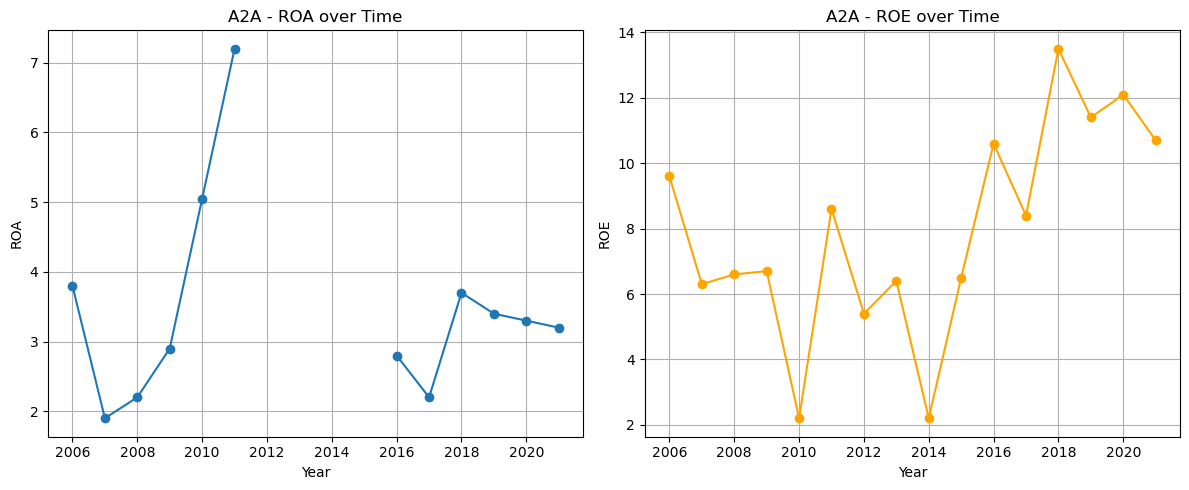

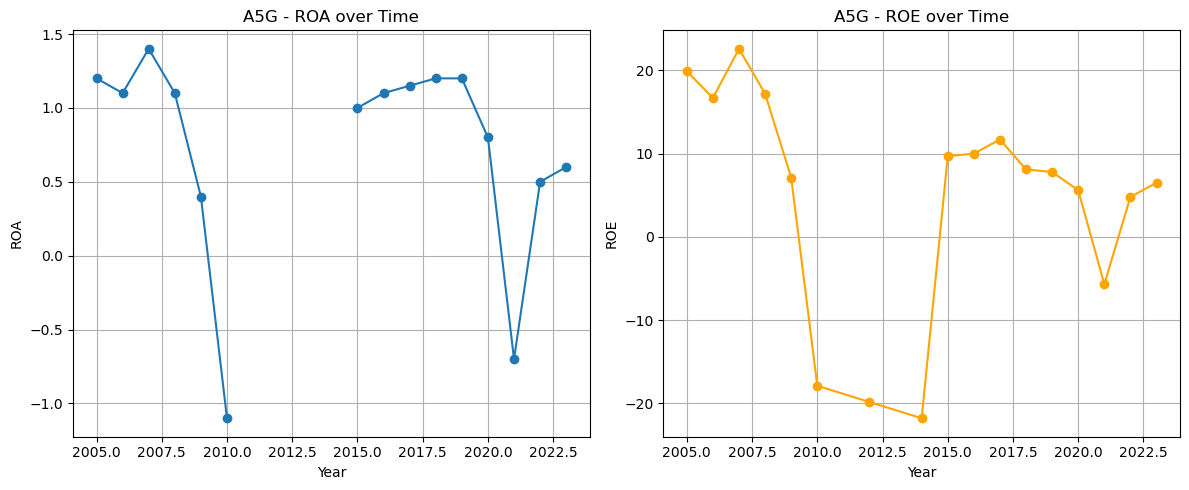

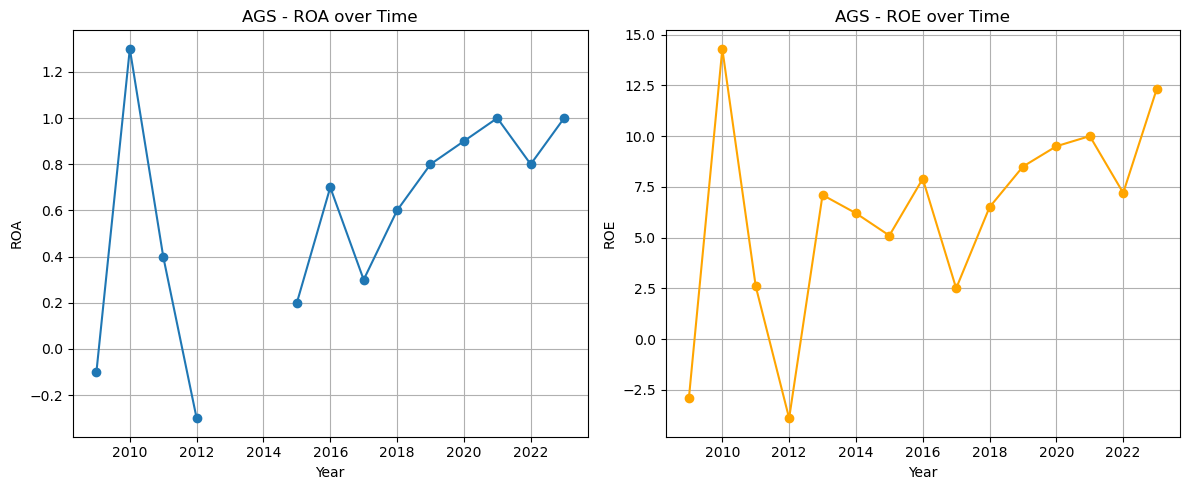

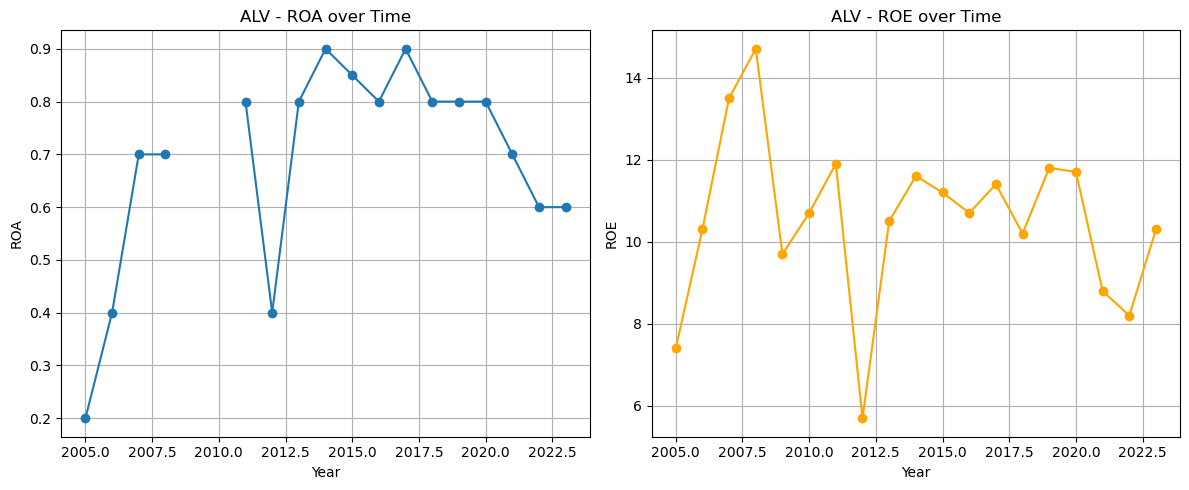

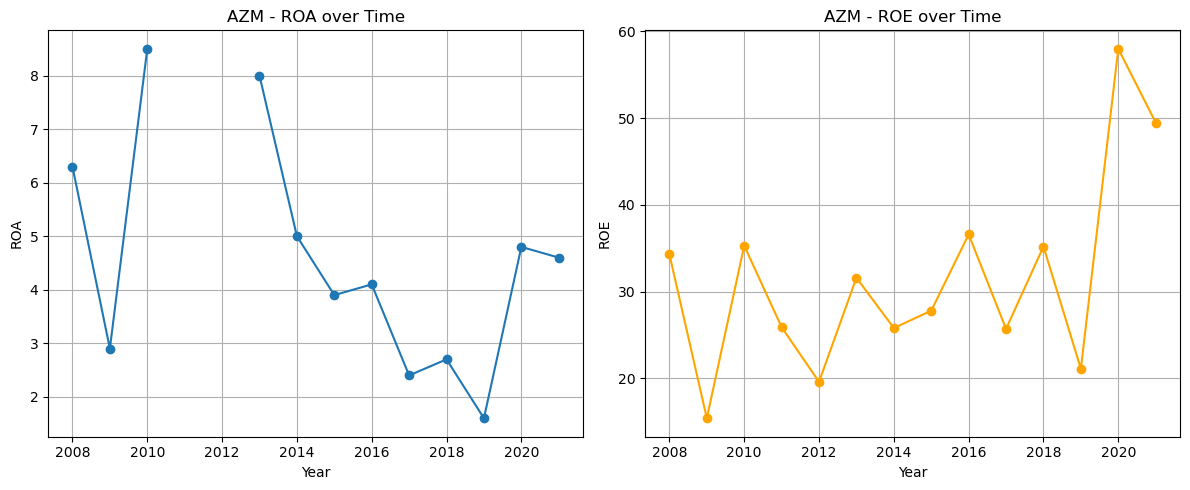

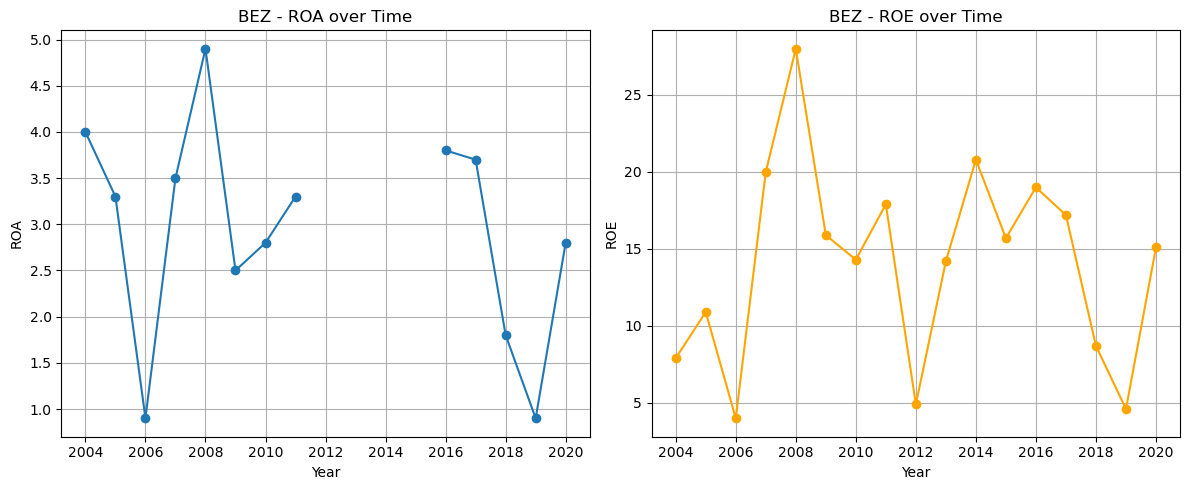

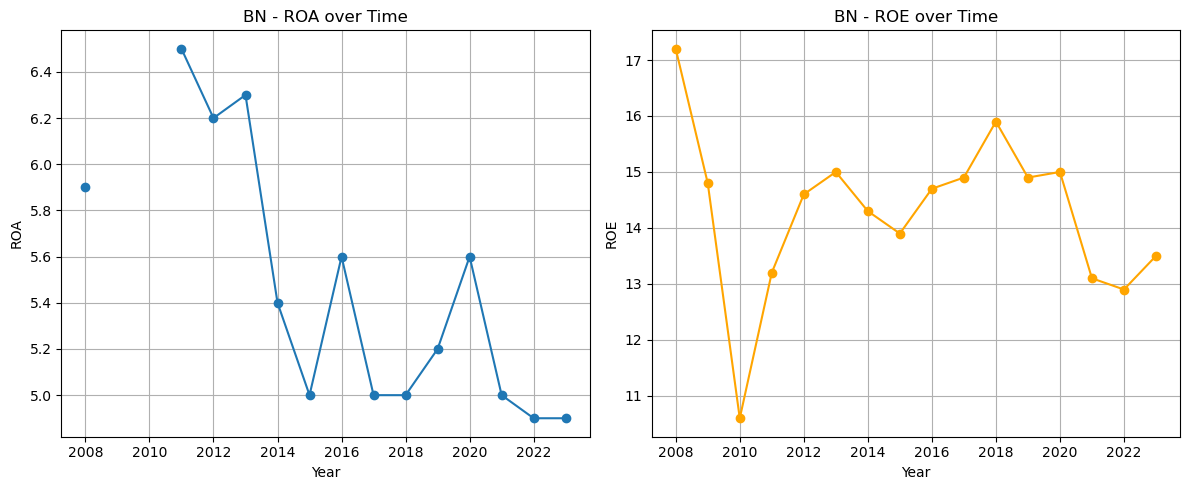

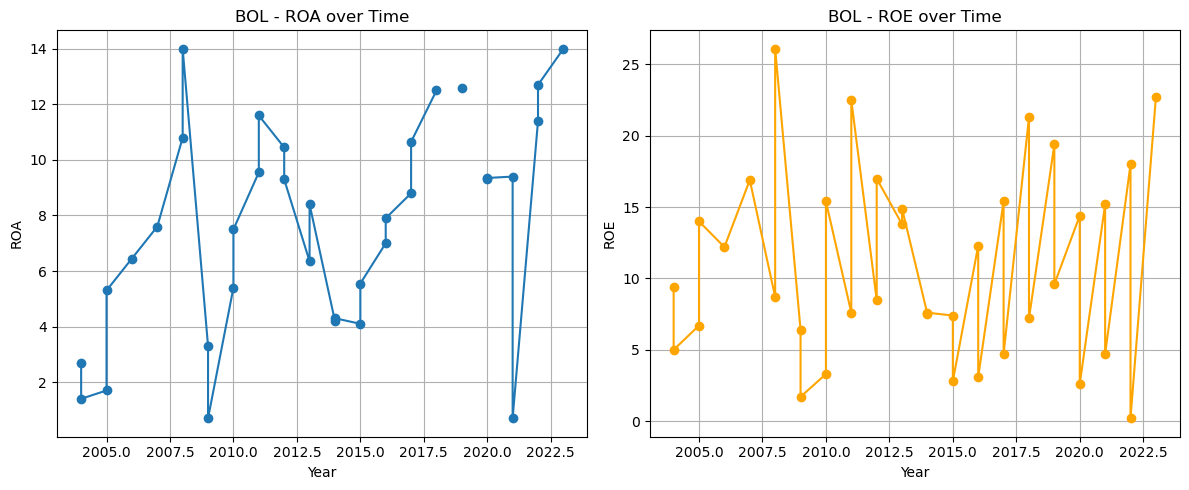

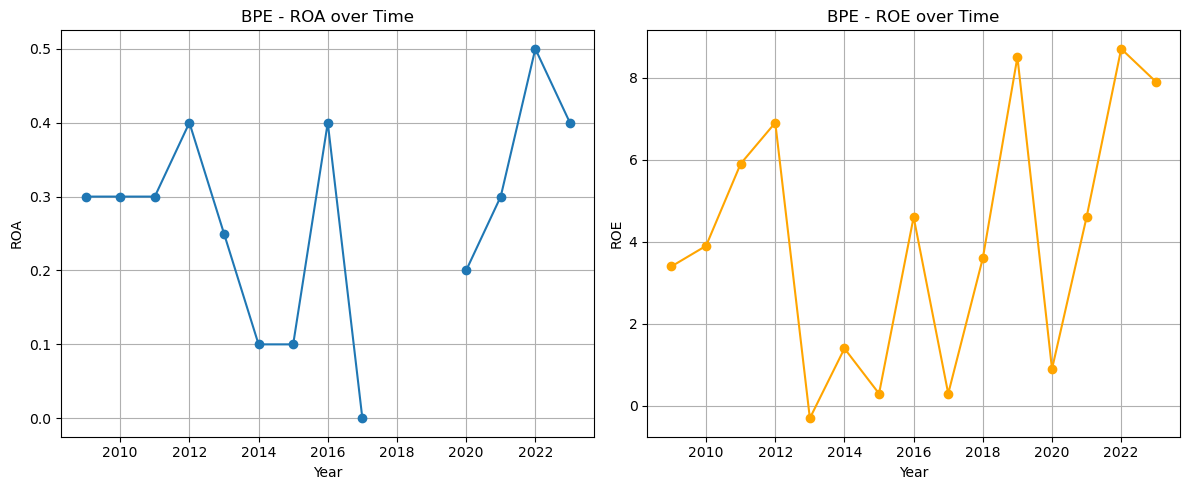

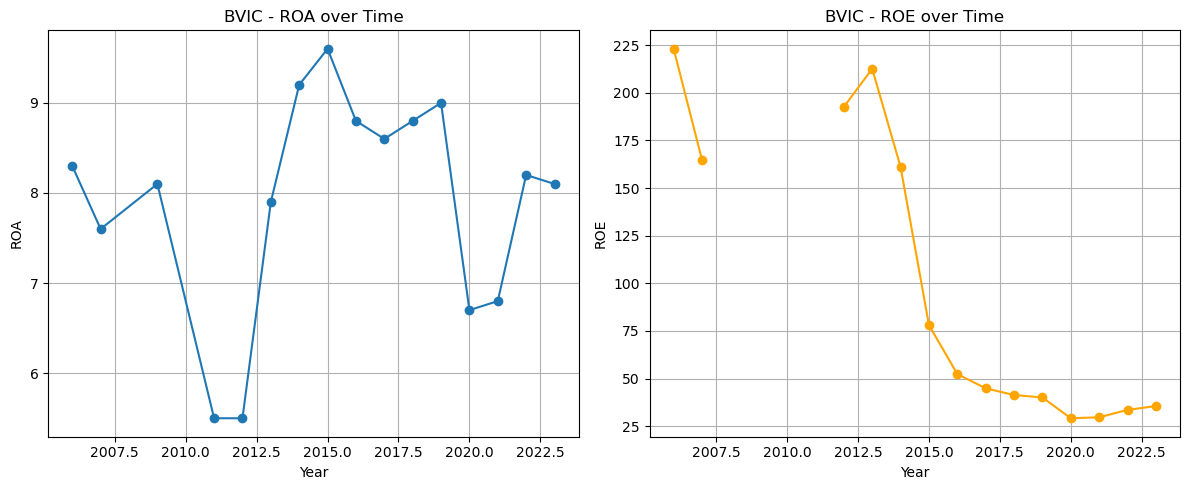

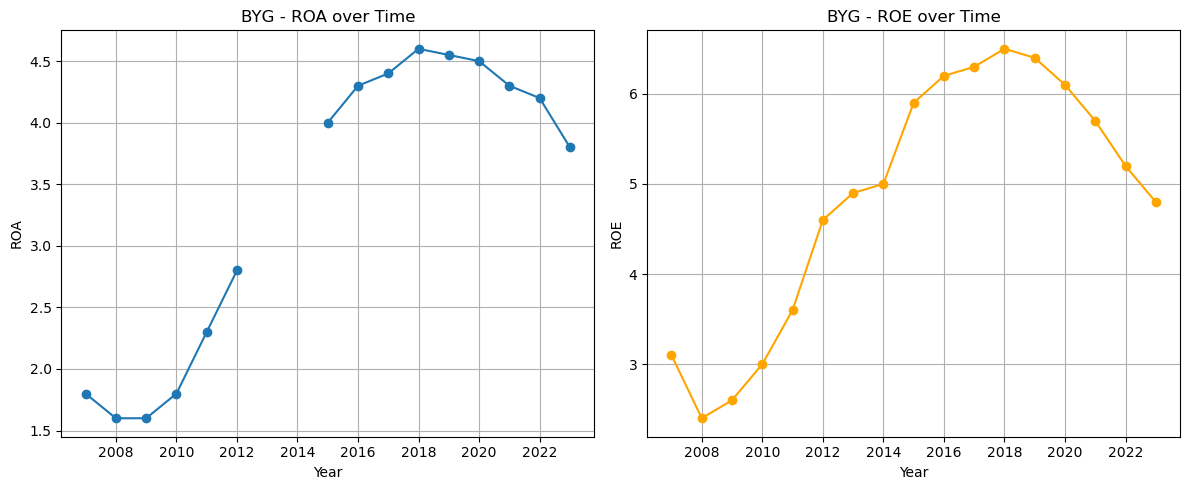

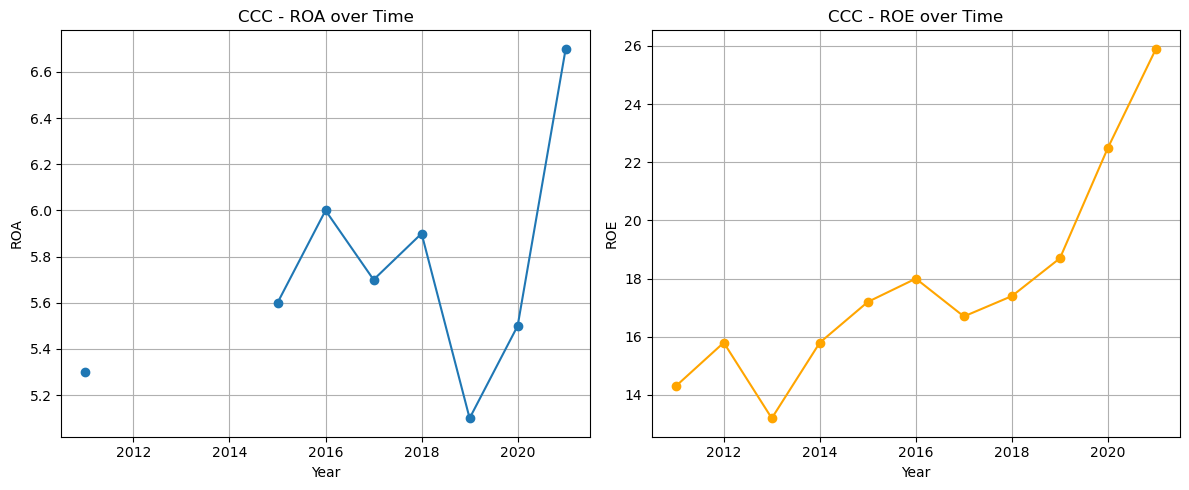

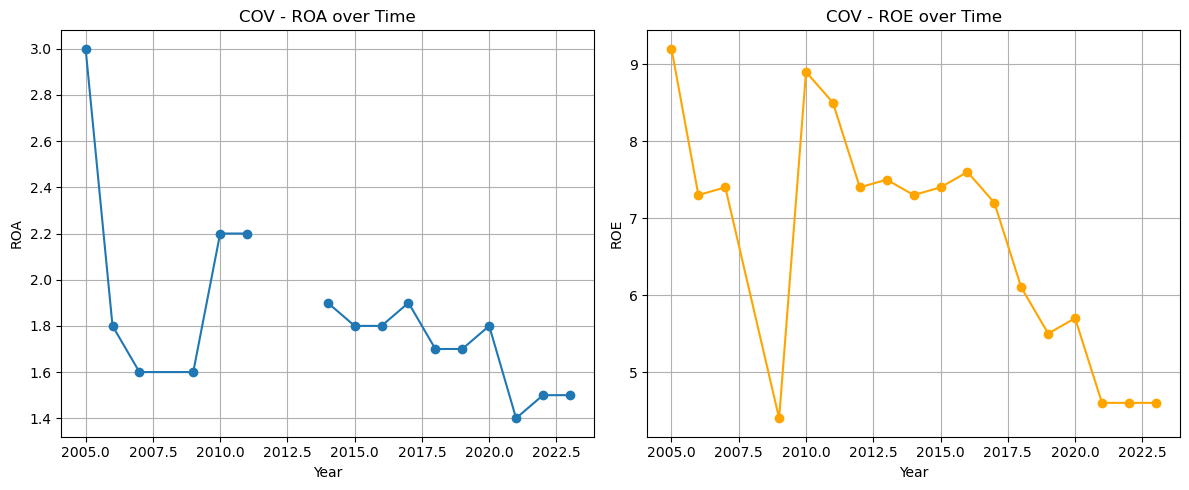

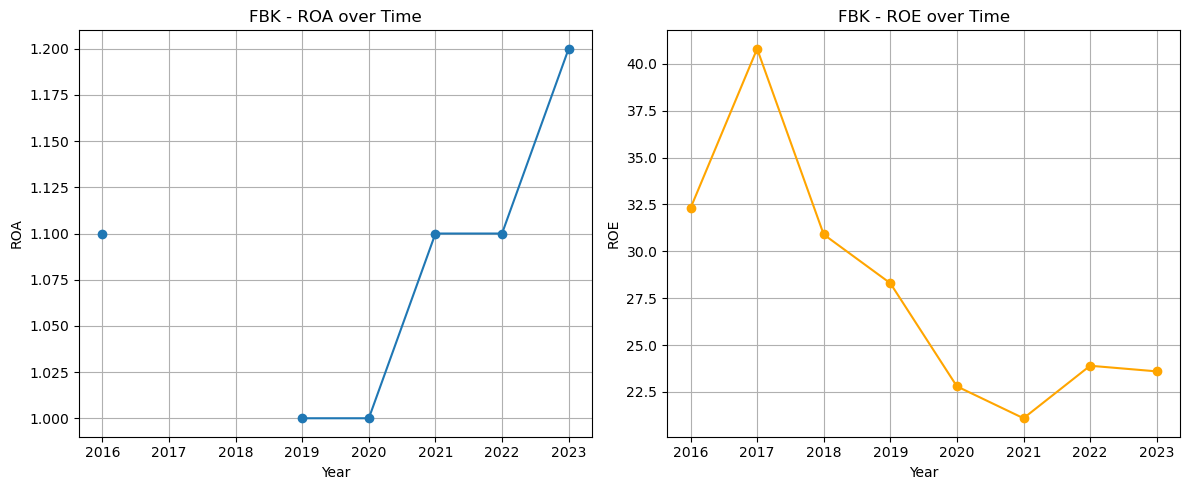

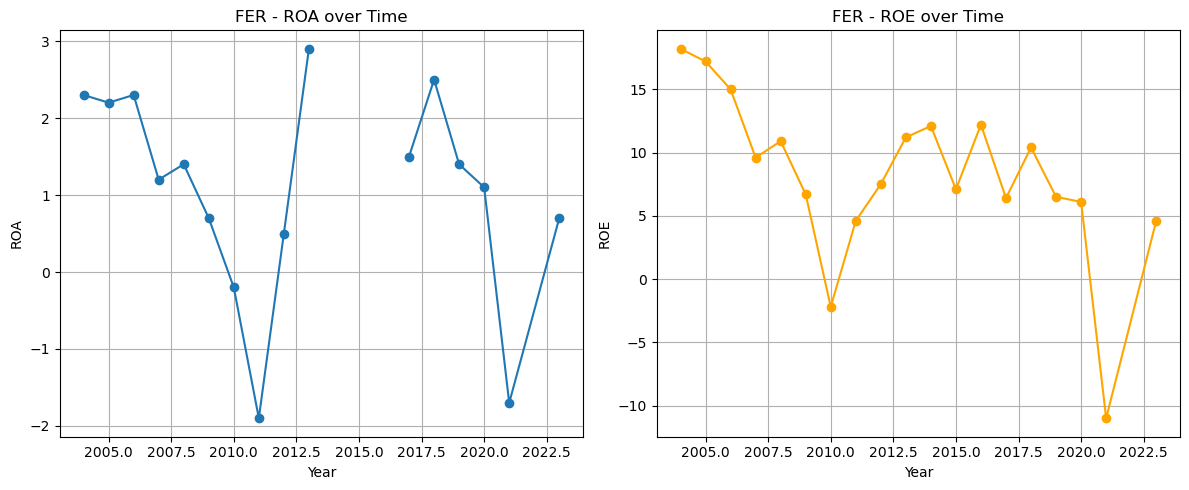

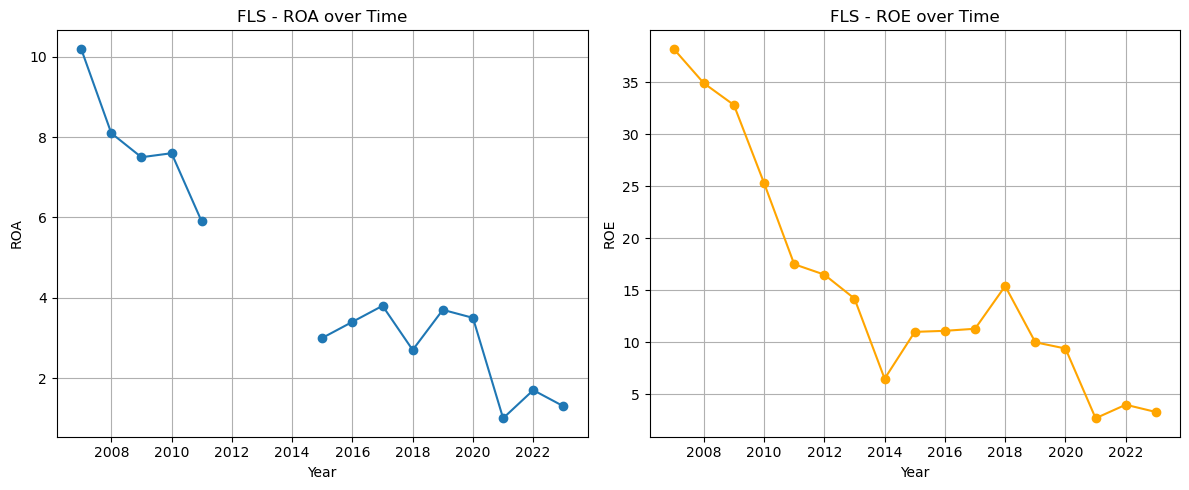

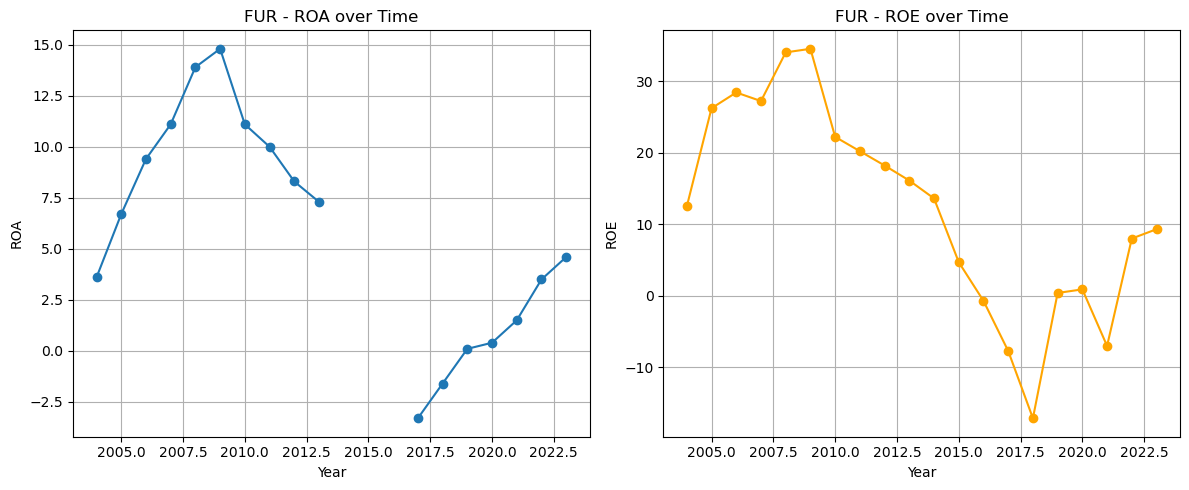

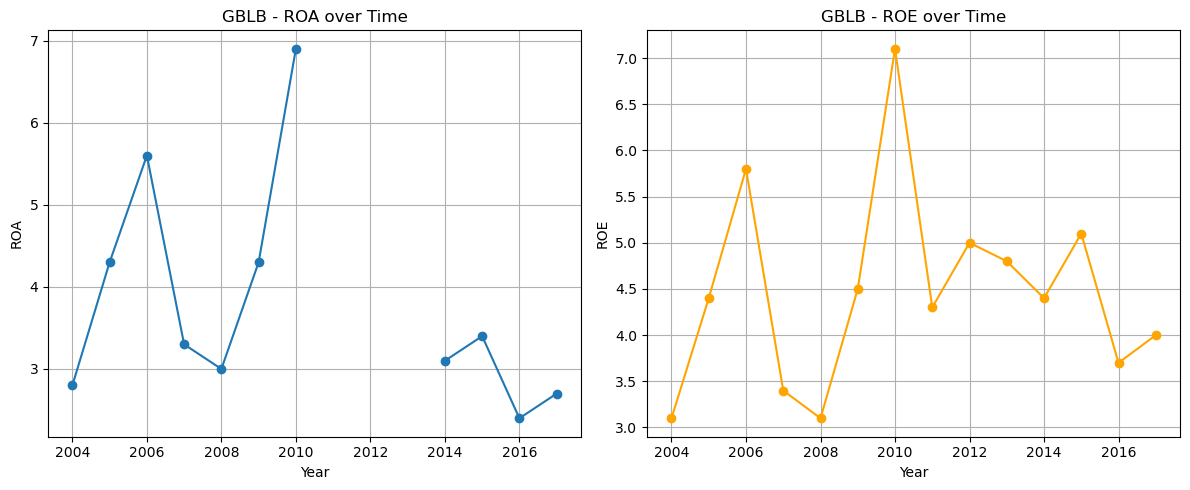

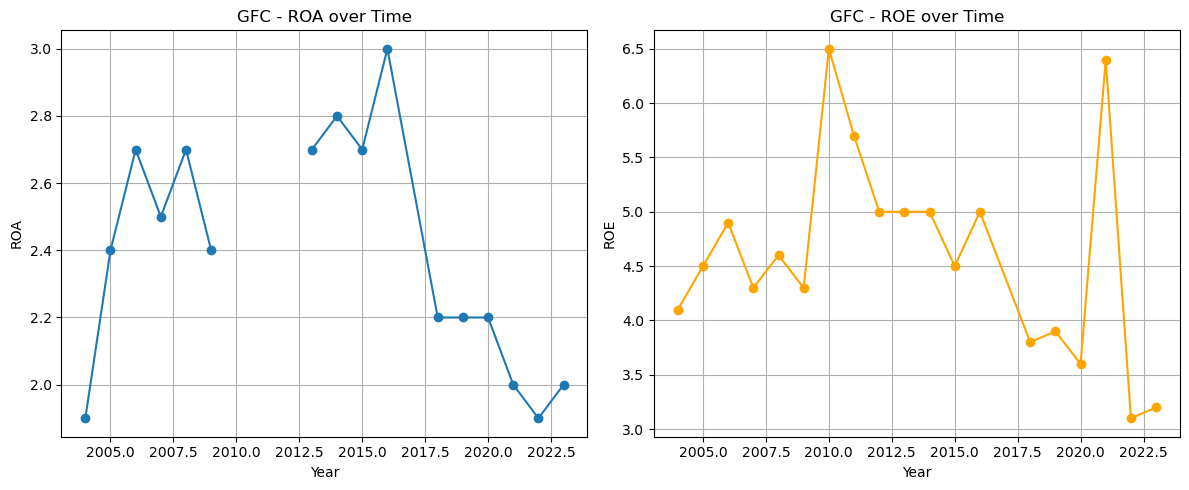

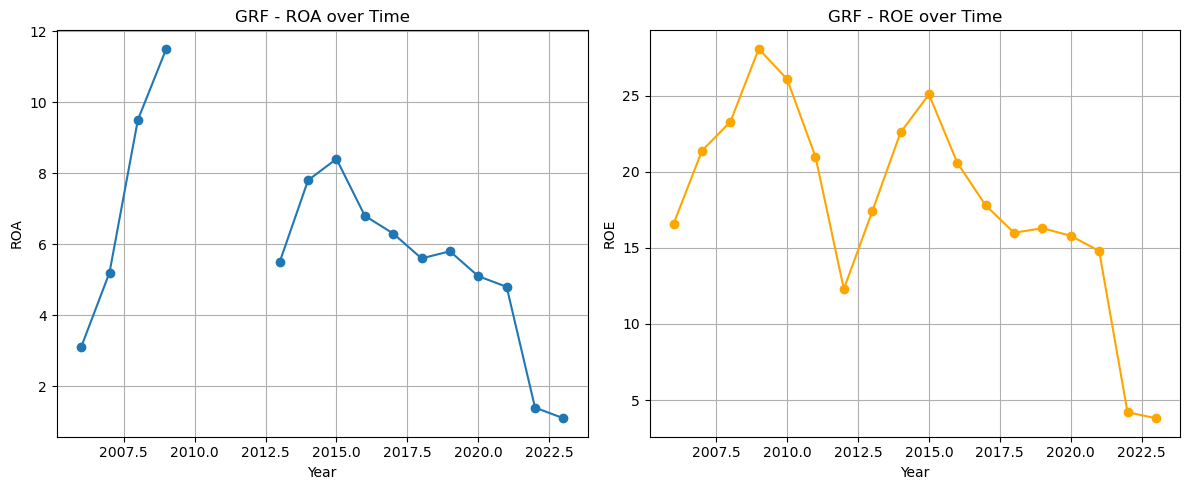

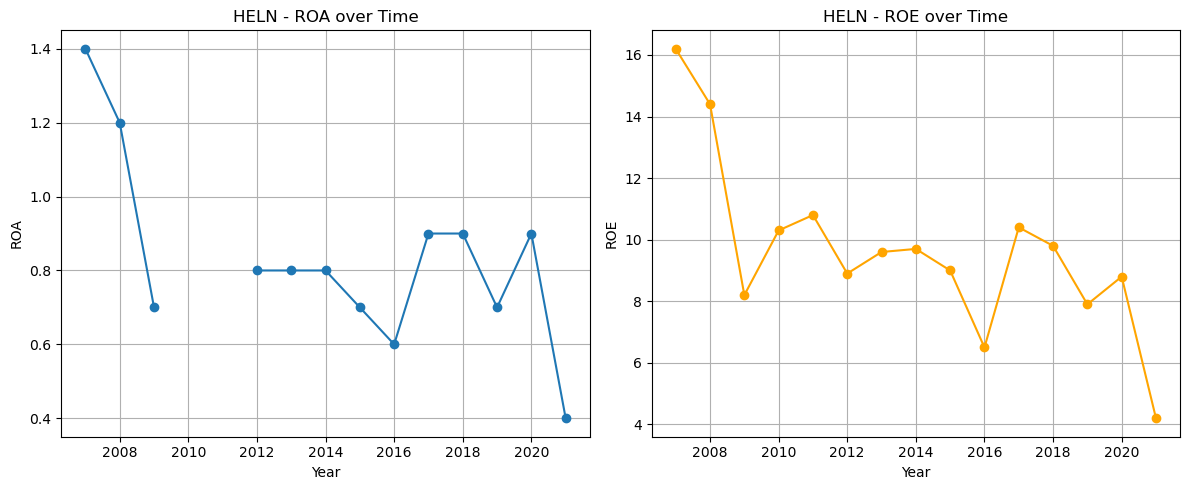

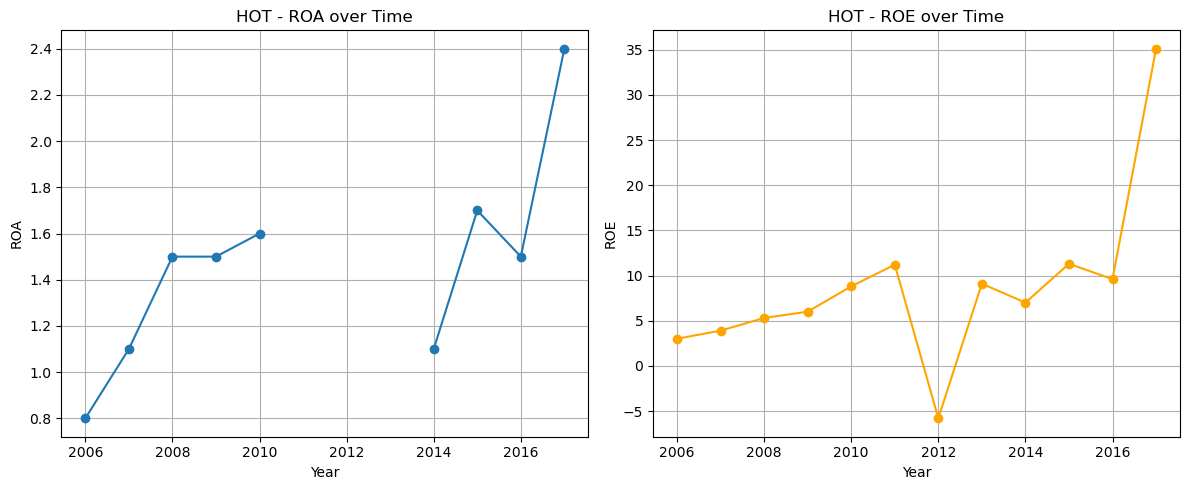

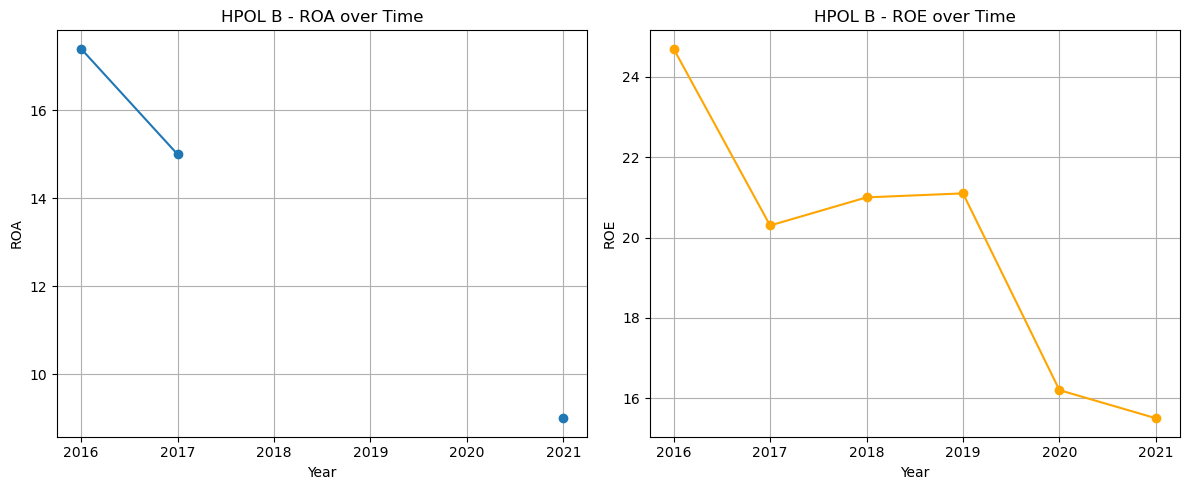

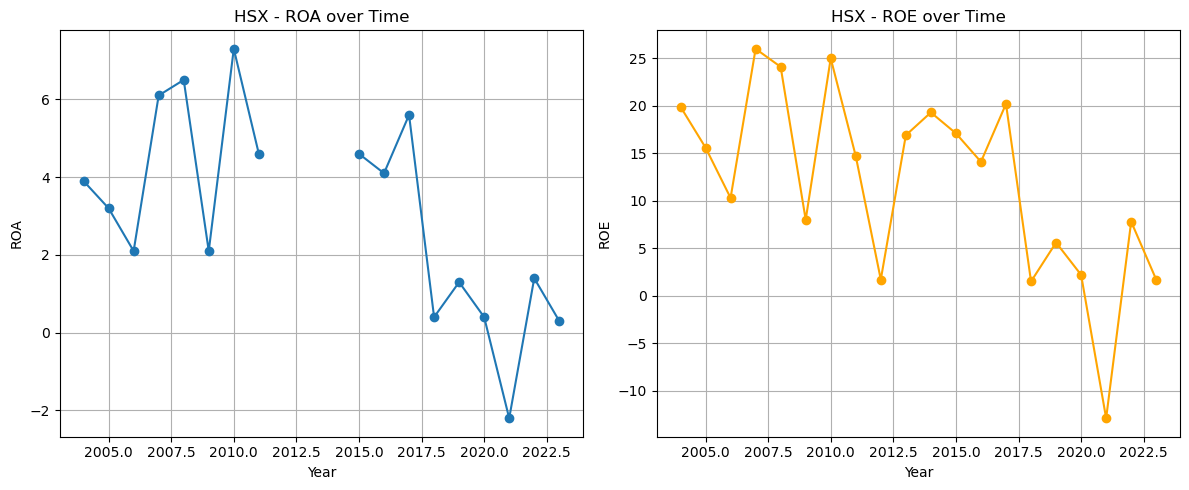

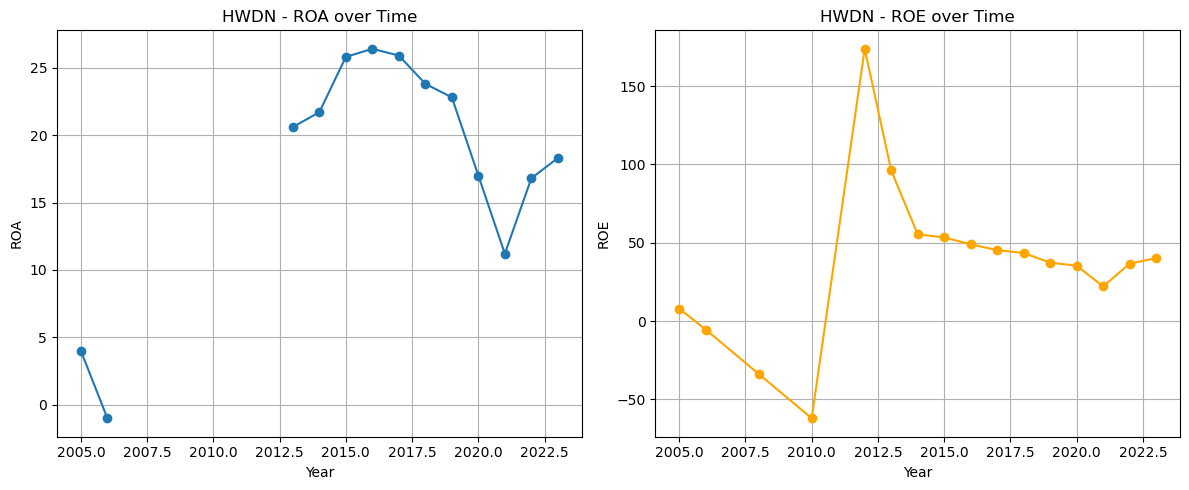

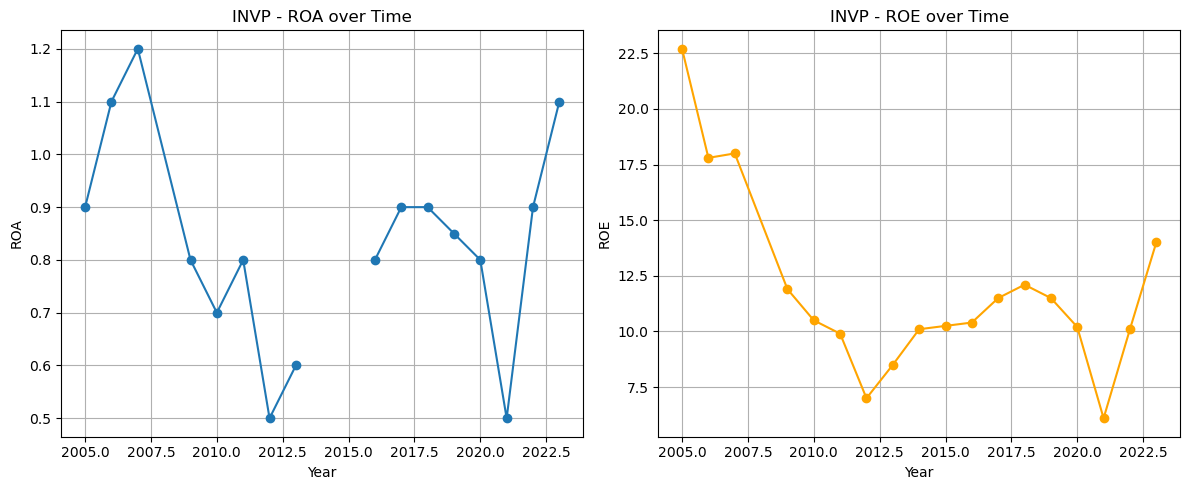

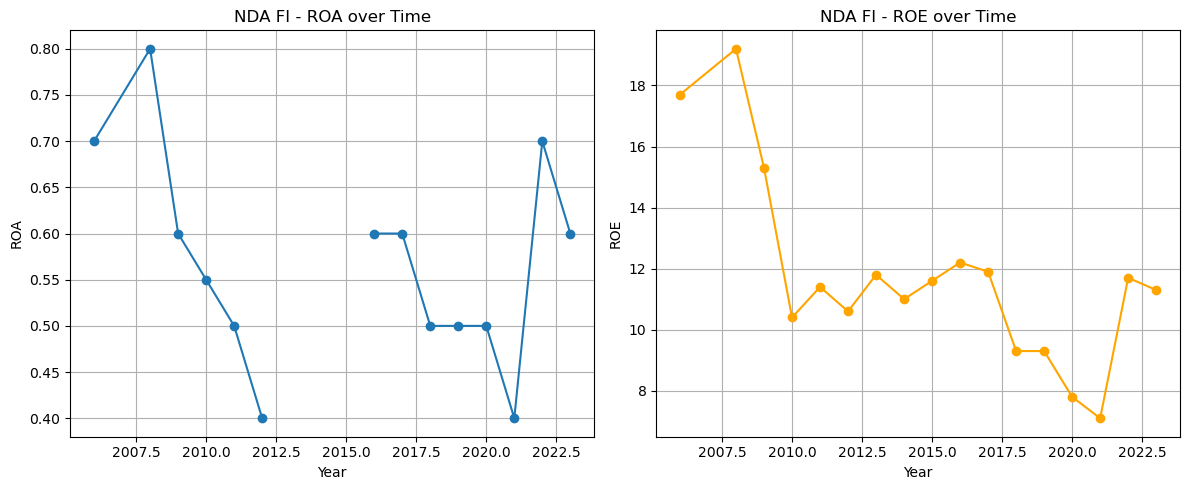

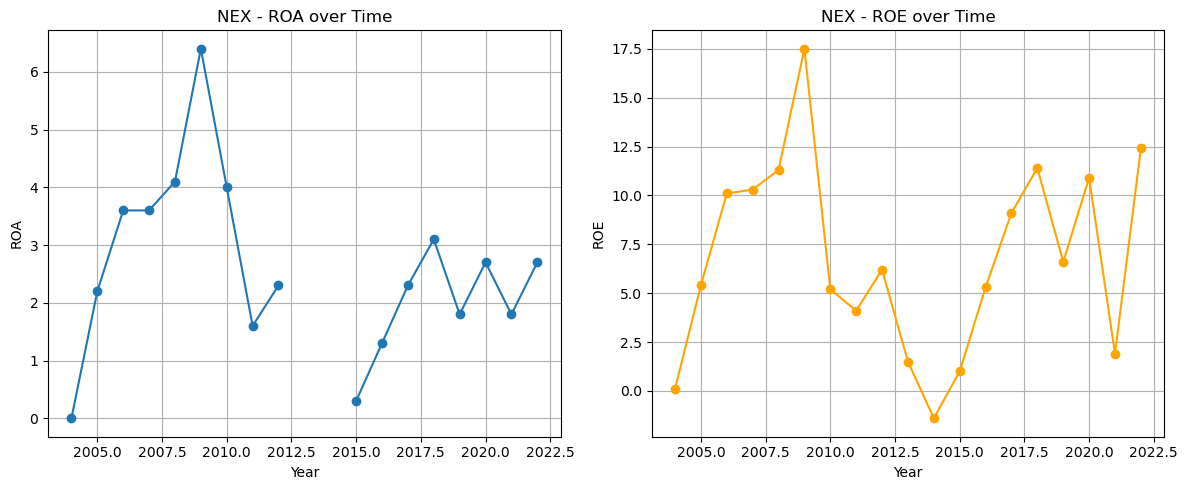

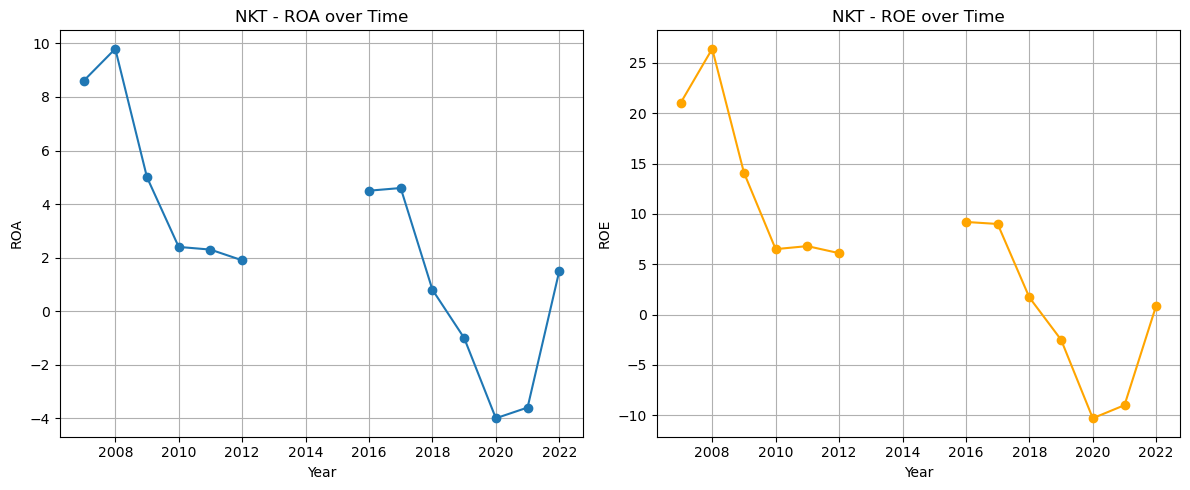

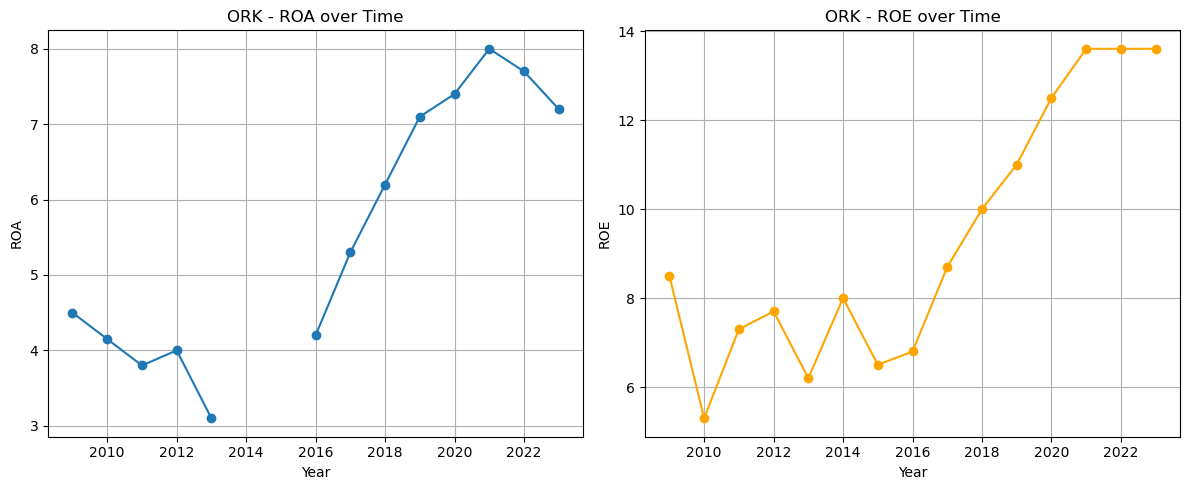

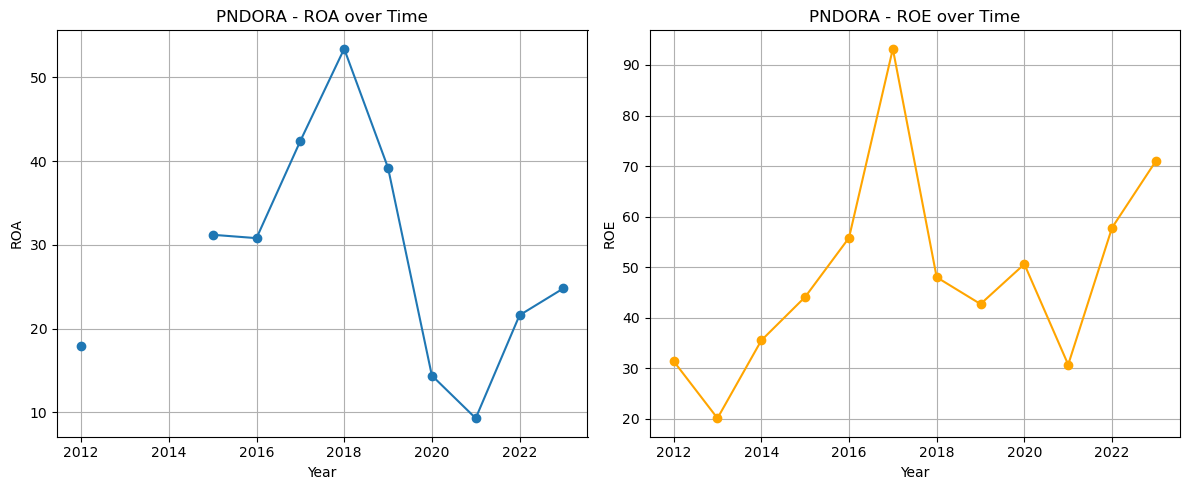

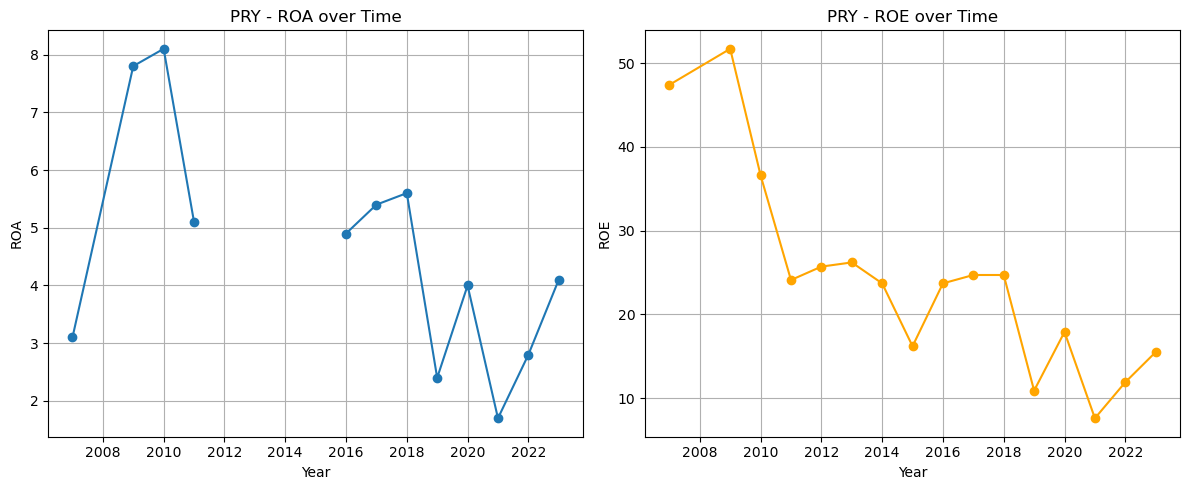

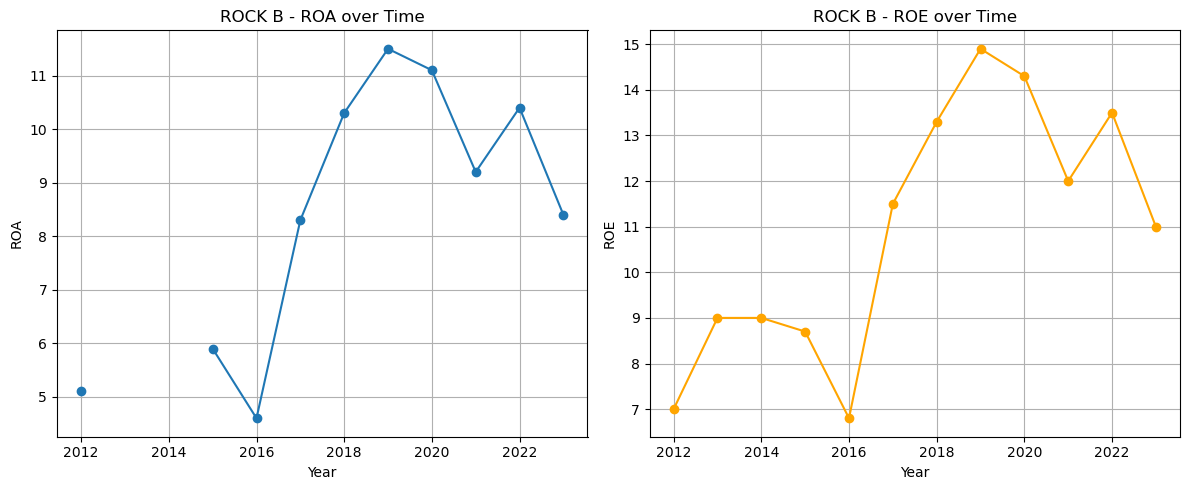

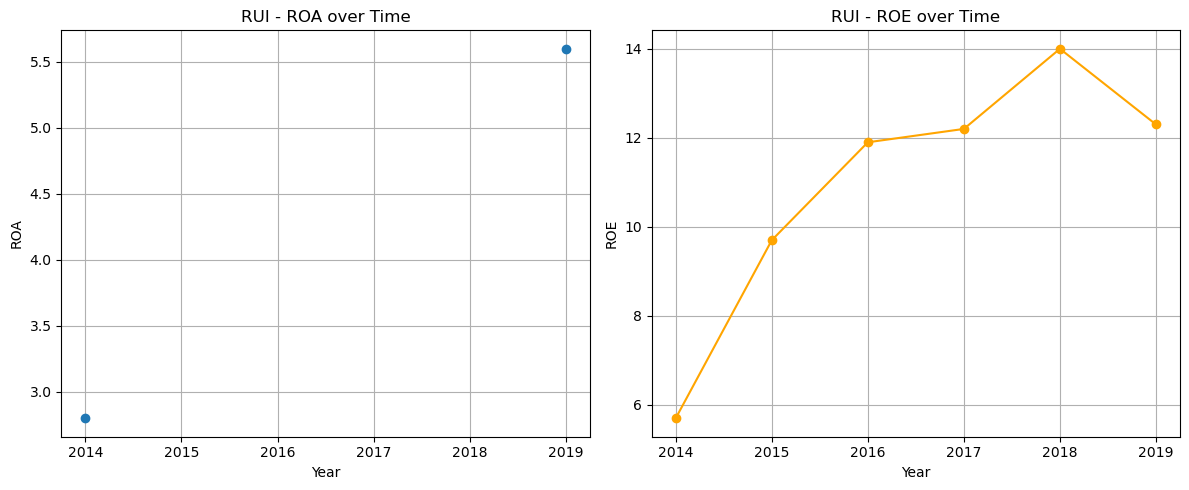

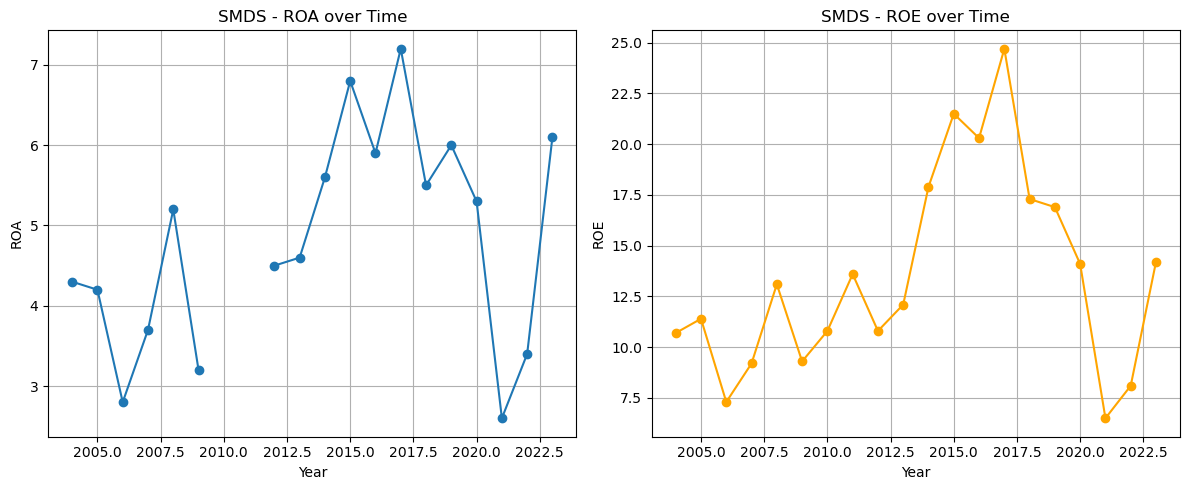

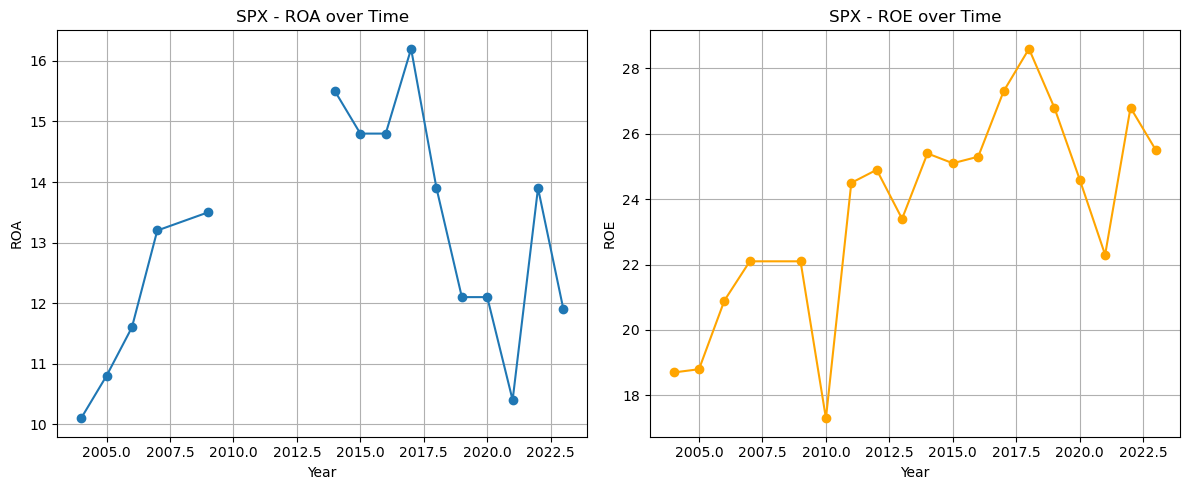

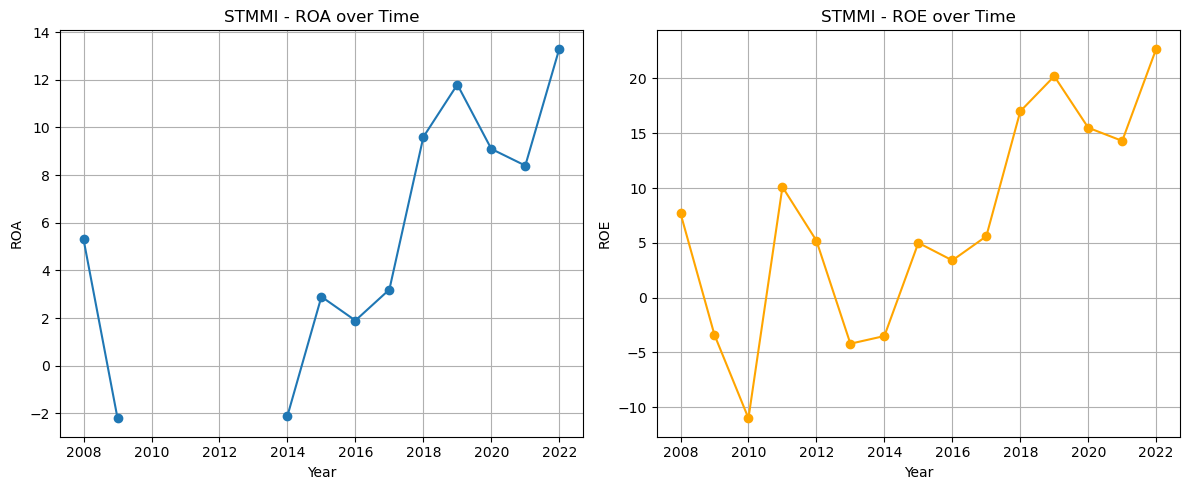

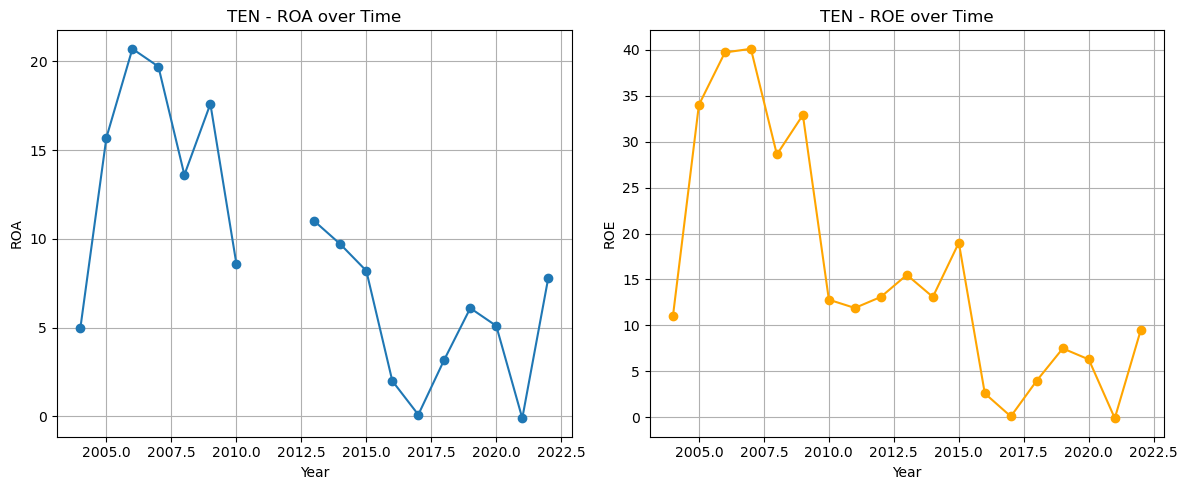

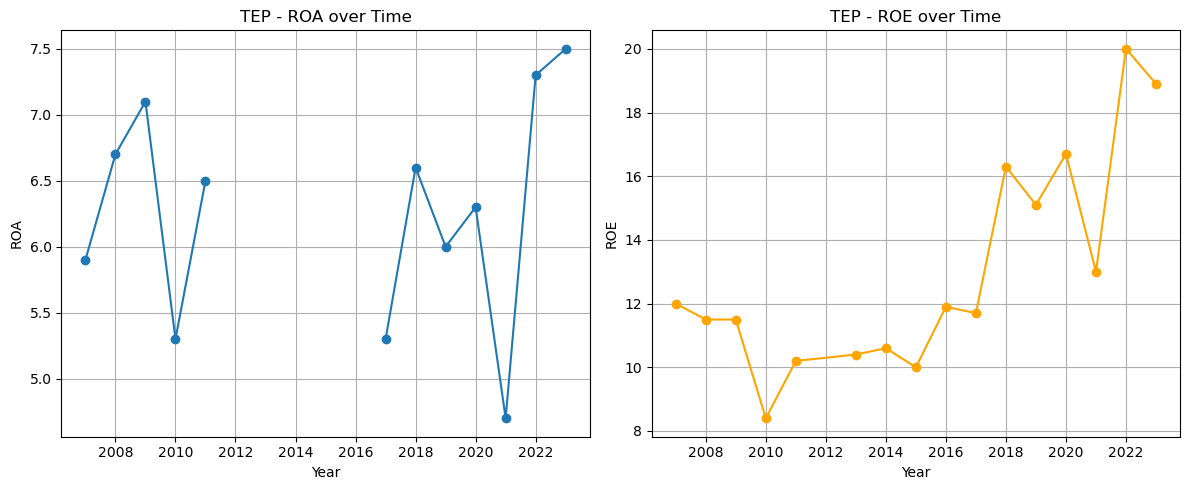

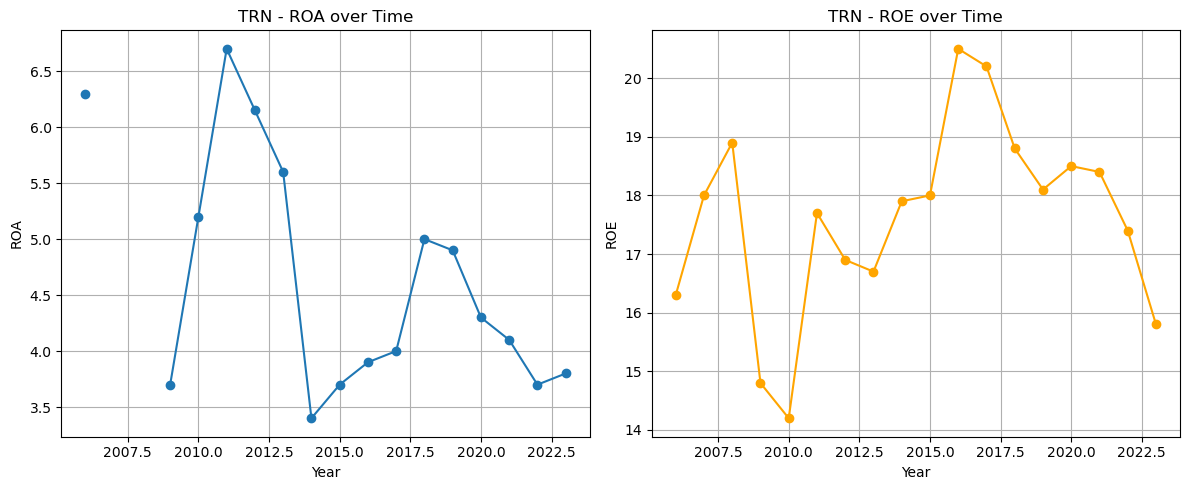

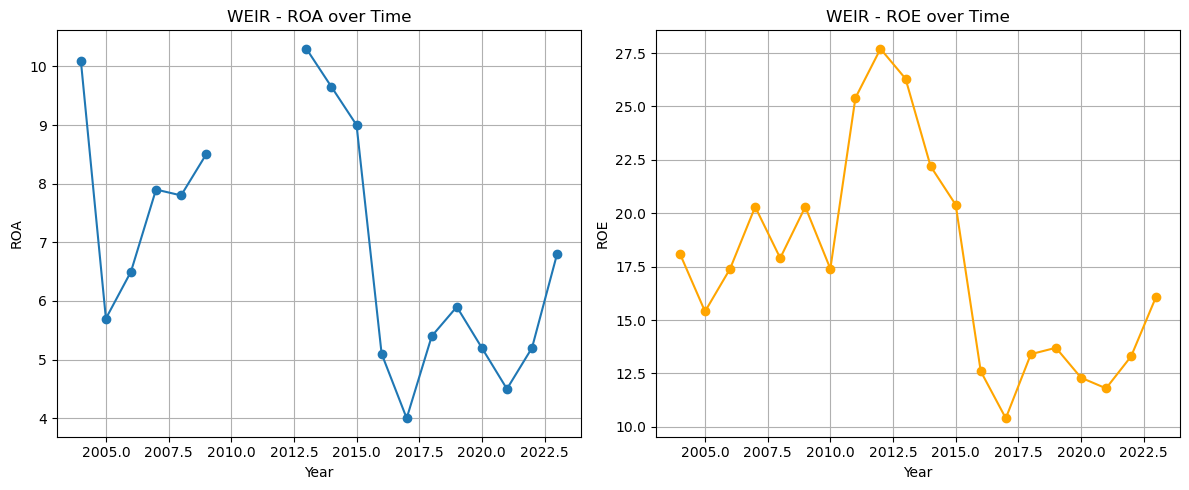

In [58]:
import matplotlib.pyplot as plt

# Step 1: Find companies with NaNs in ROA or ROE
nan_companies = df_cleaned[df_cleaned[['ROA', 'ROE']].isna().any(axis=1)]['Ticker Symbol'].unique()

# Step 2: Plot ROA and ROE over time for each of these companies
for ticker in nan_companies:
    company_data = df_cleaned[df_cleaned['Ticker Symbol'] == ticker].sort_values('Year')

    plt.figure(figsize=(12, 5))

    # ROA plot
    plt.subplot(1, 2, 1)
    plt.plot(company_data['Year'], company_data['ROA'], marker='o', linestyle='-')
    plt.title(f'{ticker} - ROA over Time')
    plt.xlabel('Year')
    plt.ylabel('ROA')
    plt.grid(True)

    # ROE plot
    plt.subplot(1, 2, 2)
    plt.plot(company_data['Year'], company_data['ROE'], marker='o', linestyle='-', color='orange')
    plt.title(f'{ticker} - ROE over Time')
    plt.xlabel('Year')
    plt.ylabel('ROE')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Implement the remaining NaN's

In [60]:
import numpy as np
import pandas as pd

def custom_linear_fill(group, column):
    values = group[column].values.copy()

    i = 0
    while i < len(values):
        if np.isnan(values[i]):
            start = i
            # Count how many NaNs in a row
            while i < len(values) and np.isnan(values[i]):
                i += 1
            end = i

            # Now fill values[start:end]
            val_before = values[start - 1] if start - 1 >= 0 else np.nan
            val_after = values[end] if end < len(values) else np.nan

            if not np.isnan(val_before) and not np.isnan(val_after):
                step = (val_after - val_before) / (end - start + 1)
                for j in range(start, end):
                    values[j] = val_before + step * (j - start + 1)
            # If one of the bounds is NaN, we can't fill – leave them as NaN
        else:
            i += 1

    group[column] = values
    return group

# Apply this for each company and each variable
for col in ['ROA', 'ROE', 'ESG_score', 'Env_score', 'Soc_score', 'Gov_score', 'ESG_Comb_score']:
    df_cleaned = df_cleaned.groupby('Ticker Symbol', group_keys=False).apply(lambda g: custom_linear_fill(g.sort_values('Year'), col))

C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\2123381877.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('Ticker Symbol', group_keys=False).apply(lambda g: custom_linear_fill(g.sort_values('Year'), col))
C:\Users\fbergsma1\AppData\Local\Temp\ipykernel_29272\2123381877.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('Ticker Sym

In [61]:
nan_per_column = df_cleaned.isna().sum()
print(nan_per_column)

Company Name                    0
Ticker Symbol                   0
Country of Exchange             0
NAICS National Industry Name    0
Year                            0
EPS                             0
ROA                             0
ROE                             0
ESG_score                       0
Env_score                       0
Soc_score                       0
Gov_score                       0
ESG_Comb_score                  0
MarketCap                       0
dtype: int64


In [62]:
df_cleaned

,Company Name,Ticker Symbol,Country of Exchange,NAICS National Industry Name,Year,EPS,ROA,ROE,ESG_score,Env_score,Soc_score,Gov_score,ESG_Comb_score,MarketCap
0,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2016,2.93,5.1,20.1,66.40,70.25,68.00,56.88,66.40,1.387610e+10
1,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2017,4.17,7.7,20.4,68.66,68.28,74.58,59.31,68.66,2.089835e+10
2,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2018,12.25,18.6,42.2,73.62,72.78,74.72,73.21,73.62,9.062689e+09
3,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2019,10.74,16.3,34.2,74.58,69.59,71.77,88.15,74.58,8.503184e+09
4,Covestro AG,1COV,Germany,Plastics Material and Resin Manufacturing,2020,3.26,4.9,10.5,76.25,74.38,69.86,90.37,76.25,1.191101e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6591,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2019,24.28,0.9,13.1,89.93,90.84,91.69,86.64,79.96,6.138598e+10
6592,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2020,27.69,1.0,12.7,88.87,89.60,90.93,85.50,50.53,6.349212e+10
6593,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2021,25.56,0.9,10.5,89.19,86.31,87.95,97.03,76.17,6.604281e+10
6594,Zurich Insurance Group AG,ZURN,Switzerland,Direct Property and Casualty Insurance Carriers,2022,34.66,1.2,13.7,87.89,85.62,87.16,94.72,78.62,7.199106e+10


In [113]:
# # Export to Excel
df_cleaned.to_excel('final_cleaned_data_EU.xlsx', index=False, engine='openpyxl')